# Bug triage with Deep Learning

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Dataset bugs

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [9]:
baseline.load_ids(DIR)

In [10]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [11]:
%%time

baseline.load_preprocess()

100%|█████████████████████████████████| 212512/212512 [26:27<00:00, 133.90it/s]


Wall time: 26min 27s


In [12]:
len(baseline.sentence_dict)

242718

## Geração de batches

### Generating tiple of batches

In [13]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 1.34 s


In [14]:
baseline.load_bugs()

100%|█████████████████████████████████| 212512/212512 [13:19<00:00, 265.81it/s]


In [15]:
%%time

batch_size = 512
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 315 ms


In [16]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 100), (512, 100), (512,))

### Validar entrada

In [17]:
%%time 

baseline.display_batch(bug_dir, 5)

Title: 
select exp
Title: 
i am on ec
Description: 
select export from the file menu for a project select jar file and click next choose the appropriate settings to create the jar file but make sure that the jar file doesn t already exist that the name appears in the drop down list in other words it was created previously and been deleted and that it was not the last jar file created select the path using the drop down control i e do not type into the text field click finish check to see if the jar file was created it shouldn t have been the problem appears to be that at least number character must be typed into the text field before the dialog can properly pick up the name
Description: 
i am on eclipse numbermnumber on mac os x number i have been trying to get a working cvs repository location set up that is another story so i have been setting up locations many times i go to window show view other and picked cvs repository then i go to the contextual menu item new repository location

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [18]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [11:55, 2679.55it/s] 


Total 1917494 word vectors in Glove 42B 300d.
Found 154042 unique tokens.


100%|██████████████████████████████| 154042/154042 [00:00<00:00, 239325.26it/s]


Wall time: 14min 37s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [19]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=32, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=64, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [20]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 100
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [21]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [22]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

    encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [ ]:
%%time
import keras
from keras.callbacks import ModelCheckpoint

# Inspired on https://pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)
# checkpoint
filepath="baseline_1000epoch_10steps_512batch(eclipse).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                               #validation_data=test_gen, # 
                                             epochs = 1000,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

10/10 [==============================] - ETA: 4:35 - loss: 0.9695 - pos_distance: 0.3378 - neg_distance: 0.307 - ETA: 3:46 - loss: 0.9753 - pos_distance: 0.3500 - neg_distance: 0.325 - ETA: 3:14 - loss: 0.9770 - pos_distance: 0.3563 - neg_distance: 0.333 - ETA: 2:43 - loss: 0.9765 - pos_distance: 0.3715 - neg_distance: 0.348 - ETA: 2:15 - loss: 0.9788 - pos_distance: 0.3803 - neg_distance: 0.359 - ETA: 1:47 - loss: 0.9785 - pos_distance: 0.3836 - neg_distance: 0.362 - ETA: 1:20 - loss: 0.9783 - pos_distance: 0.3749 - neg_distance: 0.353 - ETA: 53s - loss: 0.9782 - pos_distance: 0.3661 - neg_distance: 0.344 - ETA: 26s - loss: 0.9768 - pos_distance: 0.3665 - neg_distance: 0.34 - 265s 27s/step - loss: 0.9739 - pos_distance: 0.3729 - neg_distance: 0.3467

Epoch 00005: loss improved from 0.97828 to 0.97387, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 6/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.9790 - pos_distance: 0.5209 - neg_distance: 0.

10/10 [==============================] - ETA: 3:45 - loss: 0.9746 - pos_distance: 0.2249 - neg_distance: 0.199 - ETA: 3:24 - loss: 0.9742 - pos_distance: 0.2418 - neg_distance: 0.216 - ETA: 2:59 - loss: 0.9736 - pos_distance: 0.2717 - neg_distance: 0.245 - ETA: 2:33 - loss: 0.9696 - pos_distance: 0.3103 - neg_distance: 0.279 - ETA: 2:06 - loss: 0.9655 - pos_distance: 0.3530 - neg_distance: 0.318 - ETA: 1:41 - loss: 0.9655 - pos_distance: 0.3856 - neg_distance: 0.351 - ETA: 1:15 - loss: 0.9668 - pos_distance: 0.4026 - neg_distance: 0.369 - ETA: 52s - loss: 0.9656 - pos_distance: 0.4129 - neg_distance: 0.378 - ETA: 25s - loss: 0.9653 - pos_distance: 0.4137 - neg_distance: 0.37 - 258s 26s/step - loss: 0.9660 - pos_distance: 0.4092 - neg_distance: 0.3752

Epoch 00014: loss did not improve from 0.96371
Epoch 15/1000
10/10 [==============================] - ETA: 3:44 - loss: 0.9657 - pos_distance: 0.3041 - neg_distance: 0.269 - ETA: 3:21 - loss: 0.9658 - pos_distance: 0.3035 - neg_distance: 

Epoch 00023: loss did not improve from 0.96371
Epoch 24/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.9584 - pos_distance: 0.4000 - neg_distance: 0.358 - ETA: 3:20 - loss: 0.9607 - pos_distance: 0.4110 - neg_distance: 0.371 - ETA: 2:55 - loss: 0.9583 - pos_distance: 0.4103 - neg_distance: 0.368 - ETA: 2:29 - loss: 0.9628 - pos_distance: 0.4078 - neg_distance: 0.370 - ETA: 2:04 - loss: 0.9635 - pos_distance: 0.4044 - neg_distance: 0.367 - ETA: 1:39 - loss: 0.9617 - pos_distance: 0.3963 - neg_distance: 0.358 - ETA: 1:15 - loss: 0.9616 - pos_distance: 0.3900 - neg_distance: 0.351 - ETA: 50s - loss: 0.9604 - pos_distance: 0.3917 - neg_distance: 0.352 - ETA: 25s - loss: 0.9597 - pos_distance: 0.3969 - neg_distance: 0.35 - 253s 25s/step - loss: 0.9608 - pos_distance: 0.4010 - neg_distance: 0.3618

Epoch 00024: loss improved from 0.96371 to 0.96079, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 25/1000
10/10 [==============================] - ETA:

10/10 [==============================] - ETA: 3:49 - loss: 0.9538 - pos_distance: 0.5138 - neg_distance: 0.467 - ETA: 3:19 - loss: 0.9620 - pos_distance: 0.5136 - neg_distance: 0.475 - ETA: 2:56 - loss: 0.9597 - pos_distance: 0.4859 - neg_distance: 0.445 - ETA: 2:32 - loss: 0.9636 - pos_distance: 0.4426 - neg_distance: 0.406 - ETA: 2:06 - loss: 0.9641 - pos_distance: 0.4041 - neg_distance: 0.368 - ETA: 1:40 - loss: 0.9656 - pos_distance: 0.3772 - neg_distance: 0.342 - ETA: 1:15 - loss: 0.9647 - pos_distance: 0.3627 - neg_distance: 0.327 - ETA: 50s - loss: 0.9633 - pos_distance: 0.3587 - neg_distance: 0.322 - ETA: 25s - loss: 0.9616 - pos_distance: 0.3658 - neg_distance: 0.32 - 254s 25s/step - loss: 0.9619 - pos_distance: 0.3793 - neg_distance: 0.3412

Epoch 00033: loss did not improve from 0.95738
Epoch 34/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.9570 - pos_distance: 0.5549 - neg_distance: 0.511 - ETA: 3:27 - loss: 0.9554 - pos_distance: 0.5421 - neg_distance: 

10/10 [==============================] - ETA: 3:44 - loss: 0.9397 - pos_distance: 0.5208 - neg_distance: 0.460 - ETA: 3:25 - loss: 0.9456 - pos_distance: 0.4732 - neg_distance: 0.418 - ETA: 2:58 - loss: 0.9551 - pos_distance: 0.4381 - neg_distance: 0.393 - ETA: 2:33 - loss: 0.9520 - pos_distance: 0.4201 - neg_distance: 0.372 - ETA: 2:08 - loss: 0.9537 - pos_distance: 0.4096 - neg_distance: 0.363 - ETA: 1:43 - loss: 0.9510 - pos_distance: 0.4167 - neg_distance: 0.367 - ETA: 1:17 - loss: 0.9478 - pos_distance: 0.4317 - neg_distance: 0.379 - ETA: 51s - loss: 0.9499 - pos_distance: 0.4502 - neg_distance: 0.400 - ETA: 25s - loss: 0.9512 - pos_distance: 0.4547 - neg_distance: 0.40 - 255s 26s/step - loss: 0.9505 - pos_distance: 0.4491 - neg_distance: 0.3996

Epoch 00042: loss did not improve from 0.95015
Epoch 43/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.9489 - pos_distance: 0.3463 - neg_distance: 0.295 - ETA: 3:18 - loss: 0.9549 - pos_distance: 0.3637 - neg_distance: 

10/10 [==============================] - ETA: 3:53 - loss: 0.9399 - pos_distance: 0.4207 - neg_distance: 0.360 - ETA: 3:23 - loss: 0.9439 - pos_distance: 0.4763 - neg_distance: 0.420 - ETA: 2:59 - loss: 0.9432 - pos_distance: 0.5046 - neg_distance: 0.447 - ETA: 2:34 - loss: 0.9423 - pos_distance: 0.4901 - neg_distance: 0.432 - ETA: 2:08 - loss: 0.9442 - pos_distance: 0.4655 - neg_distance: 0.409 - ETA: 1:42 - loss: 0.9445 - pos_distance: 0.4480 - neg_distance: 0.392 - ETA: 1:16 - loss: 0.9460 - pos_distance: 0.4412 - neg_distance: 0.387 - ETA: 51s - loss: 0.9448 - pos_distance: 0.4473 - neg_distance: 0.392 - ETA: 25s - loss: 0.9451 - pos_distance: 0.4552 - neg_distance: 0.40 - 257s 26s/step - loss: 0.9448 - pos_distance: 0.4630 - neg_distance: 0.4078

Epoch 00051: loss did not improve from 0.94237
Epoch 52/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9439 - pos_distance: 0.4792 - neg_distance: 0.423 - ETA: 3:27 - loss: 0.9459 - pos_distance: 0.4342 - neg_distance: 

10/10 [==============================] - ETA: 4:14 - loss: 0.9399 - pos_distance: 0.4869 - neg_distance: 0.426 - ETA: 3:32 - loss: 0.9441 - pos_distance: 0.5234 - neg_distance: 0.467 - ETA: 3:04 - loss: 0.9472 - pos_distance: 0.5161 - neg_distance: 0.463 - ETA: 2:38 - loss: 0.9459 - pos_distance: 0.5196 - neg_distance: 0.465 - ETA: 2:11 - loss: 0.9436 - pos_distance: 0.5106 - neg_distance: 0.454 - ETA: 1:43 - loss: 0.9439 - pos_distance: 0.4973 - neg_distance: 0.441 - ETA: 1:17 - loss: 0.9433 - pos_distance: 0.4857 - neg_distance: 0.429 - ETA: 51s - loss: 0.9410 - pos_distance: 0.4801 - neg_distance: 0.421 - ETA: 25s - loss: 0.9403 - pos_distance: 0.4848 - neg_distance: 0.42 - 256s 26s/step - loss: 0.9397 - pos_distance: 0.4934 - neg_distance: 0.4331

Epoch 00060: loss did not improve from 0.93773
Epoch 61/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.9267 - pos_distance: 0.5079 - neg_distance: 0.434 - ETA: 3:25 - loss: 0.9174 - pos_distance: 0.4731 - neg_distance: 

10/10 [==============================] - ETA: 4:01 - loss: 0.9560 - pos_distance: 0.4375 - neg_distance: 0.393 - ETA: 3:29 - loss: 0.9471 - pos_distance: 0.3895 - neg_distance: 0.336 - ETA: 2:58 - loss: 0.9426 - pos_distance: 0.3773 - neg_distance: 0.320 - ETA: 2:33 - loss: 0.9352 - pos_distance: 0.4003 - neg_distance: 0.335 - ETA: 2:07 - loss: 0.9379 - pos_distance: 0.4323 - neg_distance: 0.370 - ETA: 1:41 - loss: 0.9398 - pos_distance: 0.4576 - neg_distance: 0.397 - ETA: 1:16 - loss: 0.9418 - pos_distance: 0.4510 - neg_distance: 0.392 - ETA: 50s - loss: 0.9444 - pos_distance: 0.4348 - neg_distance: 0.379 - ETA: 25s - loss: 0.9447 - pos_distance: 0.4242 - neg_distance: 0.36 - 254s 25s/step - loss: 0.9447 - pos_distance: 0.4176 - neg_distance: 0.3623

Epoch 00069: loss did not improve from 0.93615
Epoch 70/1000
10/10 [==============================] - ETA: 3:38 - loss: 0.9596 - pos_distance: 0.4175 - neg_distance: 0.377 - ETA: 3:17 - loss: 0.9430 - pos_distance: 0.4597 - neg_distance: 


Epoch 00078: loss improved from 0.93246 to 0.93199, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 79/1000
10/10 [==============================] - ETA: 4:14 - loss: 0.9463 - pos_distance: 0.3835 - neg_distance: 0.329 - ETA: 3:35 - loss: 0.9359 - pos_distance: 0.4087 - neg_distance: 0.344 - ETA: 3:03 - loss: 0.9355 - pos_distance: 0.4376 - neg_distance: 0.373 - ETA: 2:36 - loss: 0.9375 - pos_distance: 0.4538 - neg_distance: 0.391 - ETA: 2:10 - loss: 0.9351 - pos_distance: 0.4648 - neg_distance: 0.399 - ETA: 1:43 - loss: 0.9376 - pos_distance: 0.4667 - neg_distance: 0.404 - ETA: 1:17 - loss: 0.9375 - pos_distance: 0.4619 - neg_distance: 0.399 - ETA: 51s - loss: 0.9364 - pos_distance: 0.4627 - neg_distance: 0.399 - ETA: 25s - loss: 0.9336 - pos_distance: 0.4662 - neg_distance: 0.39 - 258s 26s/step - loss: 0.9344 - pos_distance: 0.4753 - neg_distance: 0.4097

Epoch 00079: loss did not improve from 0.93199
Epoch 80/1000
10/10 [==============================] - ETA

10/10 [==============================] - ETA: 3:52 - loss: 0.9194 - pos_distance: 0.5563 - neg_distance: 0.475 - ETA: 3:22 - loss: 0.9342 - pos_distance: 0.5517 - neg_distance: 0.485 - ETA: 2:59 - loss: 0.9393 - pos_distance: 0.5199 - neg_distance: 0.459 - ETA: 2:32 - loss: 0.9357 - pos_distance: 0.4785 - neg_distance: 0.414 - ETA: 2:07 - loss: 0.9344 - pos_distance: 0.4544 - neg_distance: 0.388 - ETA: 1:41 - loss: 0.9355 - pos_distance: 0.4601 - neg_distance: 0.395 - ETA: 1:16 - loss: 0.9341 - pos_distance: 0.4692 - neg_distance: 0.403 - ETA: 50s - loss: 0.9331 - pos_distance: 0.4755 - neg_distance: 0.408 - ETA: 25s - loss: 0.9345 - pos_distance: 0.4724 - neg_distance: 0.40 - 253s 25s/step - loss: 0.9343 - pos_distance: 0.4627 - neg_distance: 0.3971

Epoch 00088: loss did not improve from 0.92269
Epoch 89/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9339 - pos_distance: 0.3726 - neg_distance: 0.306 - ETA: 3:24 - loss: 0.9355 - pos_distance: 0.4044 - neg_distance: 

Epoch 00097: loss did not improve from 0.92269
Epoch 98/1000
10/10 [==============================] - ETA: 3:41 - loss: 0.9364 - pos_distance: 0.6249 - neg_distance: 0.561 - ETA: 3:23 - loss: 0.9245 - pos_distance: 0.6010 - neg_distance: 0.525 - ETA: 2:56 - loss: 0.9291 - pos_distance: 0.5323 - neg_distance: 0.461 - ETA: 2:32 - loss: 0.9368 - pos_distance: 0.4620 - neg_distance: 0.398 - ETA: 2:06 - loss: 0.9412 - pos_distance: 0.4128 - neg_distance: 0.354 - ETA: 1:41 - loss: 0.9442 - pos_distance: 0.3792 - neg_distance: 0.323 - ETA: 1:16 - loss: 0.9456 - pos_distance: 0.3630 - neg_distance: 0.308 - ETA: 51s - loss: 0.9435 - pos_distance: 0.3642 - neg_distance: 0.307 - ETA: 25s - loss: 0.9440 - pos_distance: 0.3809 - neg_distance: 0.32 - 257s 26s/step - loss: 0.9426 - pos_distance: 0.4062 - neg_distance: 0.3488

Epoch 00098: loss did not improve from 0.92269
Epoch 99/1000
10/10 [==============================] - ETA: 3:41 - loss: 0.9619 - pos_distance: 0.6109 - neg_distance: 0.572 - ETA


Epoch 00107: loss did not improve from 0.92269
Epoch 108/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.9262 - pos_distance: 0.3944 - neg_distance: 0.320 - ETA: 3:25 - loss: 0.9349 - pos_distance: 0.3755 - neg_distance: 0.310 - ETA: 3:00 - loss: 0.9299 - pos_distance: 0.3841 - neg_distance: 0.314 - ETA: 2:33 - loss: 0.9280 - pos_distance: 0.4046 - neg_distance: 0.332 - ETA: 2:08 - loss: 0.9280 - pos_distance: 0.4273 - neg_distance: 0.355 - ETA: 1:42 - loss: 0.9246 - pos_distance: 0.4387 - neg_distance: 0.363 - ETA: 1:16 - loss: 0.9222 - pos_distance: 0.4407 - neg_distance: 0.362 - ETA: 51s - loss: 0.9220 - pos_distance: 0.4347 - neg_distance: 0.356 - ETA: 25s - loss: 0.9252 - pos_distance: 0.4322 - neg_distance: 0.35 - 255s 25s/step - loss: 0.9247 - pos_distance: 0.4322 - neg_distance: 0.3569

Epoch 00108: loss did not improve from 0.92269
Epoch 109/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.9041 - pos_distance: 0.5264 - neg_distance: 0.430 - 

10/10 [==============================] - ETA: 3:38 - loss: 0.9301 - pos_distance: 0.4905 - neg_distance: 0.420 - ETA: 3:19 - loss: 0.9168 - pos_distance: 0.4599 - neg_distance: 0.376 - ETA: 2:54 - loss: 0.9202 - pos_distance: 0.4366 - neg_distance: 0.356 - ETA: 2:29 - loss: 0.9184 - pos_distance: 0.4284 - neg_distance: 0.346 - ETA: 2:05 - loss: 0.9196 - pos_distance: 0.4252 - neg_distance: 0.344 - ETA: 1:39 - loss: 0.9260 - pos_distance: 0.4326 - neg_distance: 0.358 - ETA: 1:15 - loss: 0.9236 - pos_distance: 0.4442 - neg_distance: 0.367 - ETA: 50s - loss: 0.9215 - pos_distance: 0.4488 - neg_distance: 0.370 - ETA: 25s - loss: 0.9200 - pos_distance: 0.4449 - neg_distance: 0.36 - 250s 25s/step - loss: 0.9223 - pos_distance: 0.4414 - neg_distance: 0.3637

Epoch 00117: loss did not improve from 0.91514
Epoch 118/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.9227 - pos_distance: 0.4507 - neg_distance: 0.373 - ETA: 3:20 - loss: 0.9145 - pos_distance: 0.4515 - neg_distance:


Epoch 00126: loss did not improve from 0.91366
Epoch 127/1000
10/10 [==============================] - ETA: 4:00 - loss: 0.9078 - pos_distance: 0.5168 - neg_distance: 0.424 - ETA: 3:33 - loss: 0.9159 - pos_distance: 0.5000 - neg_distance: 0.415 - ETA: 3:05 - loss: 0.9169 - pos_distance: 0.4817 - neg_distance: 0.398 - ETA: 2:38 - loss: 0.9120 - pos_distance: 0.4696 - neg_distance: 0.381 - ETA: 2:12 - loss: 0.9173 - pos_distance: 0.4535 - neg_distance: 0.370 - ETA: 1:45 - loss: 0.9166 - pos_distance: 0.4437 - neg_distance: 0.360 - ETA: 1:18 - loss: 0.9144 - pos_distance: 0.4575 - neg_distance: 0.371 - ETA: 52s - loss: 0.9131 - pos_distance: 0.4708 - neg_distance: 0.383 - ETA: 26s - loss: 0.9142 - pos_distance: 0.4761 - neg_distance: 0.39 - 261s 26s/step - loss: 0.9158 - pos_distance: 0.4726 - neg_distance: 0.3884

Epoch 00127: loss did not improve from 0.91366
Epoch 128/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.9285 - pos_distance: 0.3935 - neg_distance: 0.322 - 

10/10 [==============================] - ETA: 3:54 - loss: 0.9193 - pos_distance: 0.4376 - neg_distance: 0.356 - ETA: 3:29 - loss: 0.9181 - pos_distance: 0.4302 - neg_distance: 0.348 - ETA: 3:03 - loss: 0.9163 - pos_distance: 0.4353 - neg_distance: 0.351 - ETA: 2:38 - loss: 0.9201 - pos_distance: 0.4283 - neg_distance: 0.348 - ETA: 2:10 - loss: 0.9205 - pos_distance: 0.4404 - neg_distance: 0.360 - ETA: 1:44 - loss: 0.9217 - pos_distance: 0.4465 - neg_distance: 0.368 - ETA: 1:18 - loss: 0.9222 - pos_distance: 0.4466 - neg_distance: 0.368 - ETA: 52s - loss: 0.9227 - pos_distance: 0.4371 - neg_distance: 0.359 - ETA: 26s - loss: 0.9217 - pos_distance: 0.4286 - neg_distance: 0.35 - 262s 26s/step - loss: 0.9204 - pos_distance: 0.4306 - neg_distance: 0.3509

Epoch 00136: loss did not improve from 0.91322
Epoch 137/1000
10/10 [==============================] - ETA: 3:47 - loss: 0.9274 - pos_distance: 0.5374 - neg_distance: 0.464 - ETA: 3:28 - loss: 0.9283 - pos_distance: 0.5499 - neg_distance:

Epoch 00145: loss did not improve from 0.91322
Epoch 146/1000
10/10 [==============================] - ETA: 3:56 - loss: 0.9007 - pos_distance: 0.4382 - neg_distance: 0.338 - ETA: 3:28 - loss: 0.9176 - pos_distance: 0.4342 - neg_distance: 0.351 - ETA: 3:03 - loss: 0.9202 - pos_distance: 0.4536 - neg_distance: 0.373 - ETA: 2:36 - loss: 0.9238 - pos_distance: 0.4623 - neg_distance: 0.386 - ETA: 2:10 - loss: 0.9238 - pos_distance: 0.4651 - neg_distance: 0.388 - ETA: 1:44 - loss: 0.9229 - pos_distance: 0.4568 - neg_distance: 0.379 - ETA: 1:18 - loss: 0.9216 - pos_distance: 0.4504 - neg_distance: 0.372 - ETA: 52s - loss: 0.9197 - pos_distance: 0.4547 - neg_distance: 0.374 - ETA: 26s - loss: 0.9191 - pos_distance: 0.4544 - neg_distance: 0.37 - 261s 26s/step - loss: 0.9181 - pos_distance: 0.4591 - neg_distance: 0.3773

Epoch 00146: loss did not improve from 0.91322
Epoch 147/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9059 - pos_distance: 0.5040 - neg_distance: 0.410 - E

10/10 [==============================] - ETA: 3:49 - loss: 0.8931 - pos_distance: 0.4380 - neg_distance: 0.331 - ETA: 3:27 - loss: 0.9016 - pos_distance: 0.4891 - neg_distance: 0.390 - ETA: 3:02 - loss: 0.9121 - pos_distance: 0.5150 - neg_distance: 0.427 - ETA: 2:35 - loss: 0.9080 - pos_distance: 0.5248 - neg_distance: 0.432 - ETA: 2:09 - loss: 0.9124 - pos_distance: 0.5123 - neg_distance: 0.424 - ETA: 1:43 - loss: 0.9103 - pos_distance: 0.4939 - neg_distance: 0.404 - ETA: 1:17 - loss: 0.9127 - pos_distance: 0.4835 - neg_distance: 0.396 - ETA: 51s - loss: 0.9142 - pos_distance: 0.4839 - neg_distance: 0.398 - ETA: 25s - loss: 0.9131 - pos_distance: 0.4869 - neg_distance: 0.39 - 259s 26s/step - loss: 0.9157 - pos_distance: 0.4788 - neg_distance: 0.3945

Epoch 00155: loss did not improve from 0.91154
Epoch 156/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.9174 - pos_distance: 0.3750 - neg_distance: 0.292 - ETA: 3:27 - loss: 0.9163 - pos_distance: 0.3680 - neg_distance:

Epoch 00164: loss did not improve from 0.91154
Epoch 165/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9298 - pos_distance: 0.5118 - neg_distance: 0.441 - ETA: 3:24 - loss: 0.9378 - pos_distance: 0.5040 - neg_distance: 0.441 - ETA: 3:01 - loss: 0.9333 - pos_distance: 0.4624 - neg_distance: 0.395 - ETA: 2:37 - loss: 0.9400 - pos_distance: 0.4199 - neg_distance: 0.359 - ETA: 2:11 - loss: 0.9386 - pos_distance: 0.3949 - neg_distance: 0.333 - ETA: 1:45 - loss: 0.9356 - pos_distance: 0.3921 - neg_distance: 0.327 - ETA: 1:19 - loss: 0.9335 - pos_distance: 0.4115 - neg_distance: 0.345 - ETA: 52s - loss: 0.9289 - pos_distance: 0.4283 - neg_distance: 0.357 - ETA: 26s - loss: 0.9272 - pos_distance: 0.4304 - neg_distance: 0.35 - 263s 26s/step - loss: 0.9275 - pos_distance: 0.4276 - neg_distance: 0.3551

Epoch 00165: loss did not improve from 0.91154
Epoch 166/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.9187 - pos_distance: 0.4015 - neg_distance: 0.320 - E

10/10 [==============================] - ETA: 3:57 - loss: 0.9227 - pos_distance: 0.2834 - neg_distance: 0.206 - ETA: 3:29 - loss: 0.9179 - pos_distance: 0.3478 - neg_distance: 0.265 - ETA: 3:03 - loss: 0.9152 - pos_distance: 0.4097 - neg_distance: 0.324 - ETA: 2:37 - loss: 0.9148 - pos_distance: 0.4564 - neg_distance: 0.371 - ETA: 2:12 - loss: 0.9163 - pos_distance: 0.4715 - neg_distance: 0.387 - ETA: 1:45 - loss: 0.9192 - pos_distance: 0.4644 - neg_distance: 0.383 - ETA: 1:18 - loss: 0.9213 - pos_distance: 0.4473 - neg_distance: 0.368 - ETA: 52s - loss: 0.9242 - pos_distance: 0.4285 - neg_distance: 0.352 - ETA: 26s - loss: 0.9239 - pos_distance: 0.4171 - neg_distance: 0.34 - 267s 27s/step - loss: 0.9227 - pos_distance: 0.4202 - neg_distance: 0.3429

Epoch 00174: loss did not improve from 0.90658
Epoch 175/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.9017 - pos_distance: 0.4993 - neg_distance: 0.401 - ETA: 3:26 - loss: 0.9246 - pos_distance: 0.4997 - neg_distance:

Epoch 00183: loss did not improve from 0.90658
Epoch 184/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.8872 - pos_distance: 0.5296 - neg_distance: 0.416 - ETA: 3:28 - loss: 0.9117 - pos_distance: 0.5150 - neg_distance: 0.426 - ETA: 3:03 - loss: 0.9136 - pos_distance: 0.5129 - neg_distance: 0.426 - ETA: 2:35 - loss: 0.9148 - pos_distance: 0.4942 - neg_distance: 0.409 - ETA: 2:10 - loss: 0.9152 - pos_distance: 0.4697 - neg_distance: 0.384 - ETA: 1:44 - loss: 0.9175 - pos_distance: 0.4590 - neg_distance: 0.376 - ETA: 1:18 - loss: 0.9135 - pos_distance: 0.4590 - neg_distance: 0.372 - ETA: 52s - loss: 0.9125 - pos_distance: 0.4614 - neg_distance: 0.373 - ETA: 26s - loss: 0.9131 - pos_distance: 0.4551 - neg_distance: 0.36 - 262s 26s/step - loss: 0.9135 - pos_distance: 0.4499 - neg_distance: 0.3634

Epoch 00184: loss did not improve from 0.90658
Epoch 185/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.9330 - pos_distance: 0.3863 - neg_distance: 0.319 - E

10/10 [==============================] - ETA: 3:48 - loss: 0.9105 - pos_distance: 0.3960 - neg_distance: 0.306 - ETA: 3:32 - loss: 0.9170 - pos_distance: 0.3938 - neg_distance: 0.310 - ETA: 3:06 - loss: 0.9193 - pos_distance: 0.4064 - neg_distance: 0.325 - ETA: 2:38 - loss: 0.9135 - pos_distance: 0.4190 - neg_distance: 0.332 - ETA: 2:11 - loss: 0.9153 - pos_distance: 0.4290 - neg_distance: 0.344 - ETA: 1:45 - loss: 0.9172 - pos_distance: 0.4390 - neg_distance: 0.356 - ETA: 1:19 - loss: 0.9146 - pos_distance: 0.4426 - neg_distance: 0.357 - ETA: 52s - loss: 0.9187 - pos_distance: 0.4303 - neg_distance: 0.349 - ETA: 26s - loss: 0.9199 - pos_distance: 0.4167 - neg_distance: 0.33 - 264s 26s/step - loss: 0.9194 - pos_distance: 0.4051 - neg_distance: 0.3244

Epoch 00193: loss did not improve from 0.90443
Epoch 194/1000
10/10 [==============================] - ETA: 4:01 - loss: 0.9348 - pos_distance: 0.4272 - neg_distance: 0.362 - ETA: 3:32 - loss: 0.9234 - pos_distance: 0.4789 - neg_distance:

Epoch 00202: loss did not improve from 0.90443
Epoch 203/1000
10/10 [==============================] - ETA: 4:03 - loss: 0.9022 - pos_distance: 0.5483 - neg_distance: 0.450 - ETA: 3:36 - loss: 0.9162 - pos_distance: 0.5308 - neg_distance: 0.447 - ETA: 3:07 - loss: 0.9128 - pos_distance: 0.5179 - neg_distance: 0.430 - ETA: 2:41 - loss: 0.9148 - pos_distance: 0.4869 - neg_distance: 0.401 - ETA: 2:13 - loss: 0.9170 - pos_distance: 0.4609 - neg_distance: 0.377 - ETA: 1:45 - loss: 0.9169 - pos_distance: 0.4450 - neg_distance: 0.361 - ETA: 1:18 - loss: 0.9145 - pos_distance: 0.4453 - neg_distance: 0.359 - ETA: 52s - loss: 0.9139 - pos_distance: 0.4428 - neg_distance: 0.356 - ETA: 26s - loss: 0.9149 - pos_distance: 0.4456 - neg_distance: 0.36 - 265s 27s/step - loss: 0.9130 - pos_distance: 0.4483 - neg_distance: 0.3612

Epoch 00203: loss did not improve from 0.90443
Epoch 204/1000
10/10 [==============================] - ETA: 4:08 - loss: 0.9179 - pos_distance: 0.4369 - neg_distance: 0.354 - E

10/10 [==============================] - ETA: 4:17 - loss: 0.9067 - pos_distance: 0.4884 - neg_distance: 0.395 - ETA: 3:40 - loss: 0.9007 - pos_distance: 0.5019 - neg_distance: 0.402 - ETA: 3:09 - loss: 0.8967 - pos_distance: 0.4915 - neg_distance: 0.388 - ETA: 2:40 - loss: 0.8982 - pos_distance: 0.4731 - neg_distance: 0.371 - ETA: 2:13 - loss: 0.9011 - pos_distance: 0.4469 - neg_distance: 0.348 - ETA: 1:46 - loss: 0.9020 - pos_distance: 0.4255 - neg_distance: 0.327 - ETA: 1:19 - loss: 0.8995 - pos_distance: 0.4259 - neg_distance: 0.325 - ETA: 54s - loss: 0.8979 - pos_distance: 0.4363 - neg_distance: 0.334 - ETA: 27s - loss: 0.9000 - pos_distance: 0.4449 - neg_distance: 0.34 - 275s 28s/step - loss: 0.8997 - pos_distance: 0.4459 - neg_distance: 0.3457

Epoch 00212: loss improved from 0.90247 to 0.89972, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 213/1000
10/10 [==============================] - ETA: 4:21 - loss: 0.9339 - pos_distance: 0.4247 - neg_distance: 


Epoch 00221: loss did not improve from 0.89972
Epoch 222/1000
10/10 [==============================] - ETA: 5:38 - loss: 0.9121 - pos_distance: 0.4512 - neg_distance: 0.363 - ETA: 4:09 - loss: 0.9018 - pos_distance: 0.4338 - neg_distance: 0.335 - ETA: 3:26 - loss: 0.8980 - pos_distance: 0.4364 - neg_distance: 0.334 - ETA: 2:52 - loss: 0.8959 - pos_distance: 0.4467 - neg_distance: 0.342 - ETA: 2:21 - loss: 0.8993 - pos_distance: 0.4491 - neg_distance: 0.348 - ETA: 1:51 - loss: 0.8997 - pos_distance: 0.4589 - neg_distance: 0.358 - ETA: 1:23 - loss: 0.9012 - pos_distance: 0.4608 - neg_distance: 0.362 - ETA: 54s - loss: 0.9005 - pos_distance: 0.4607 - neg_distance: 0.361 - ETA: 27s - loss: 0.9017 - pos_distance: 0.4544 - neg_distance: 0.35 - 271s 27s/step - loss: 0.9032 - pos_distance: 0.4491 - neg_distance: 0.3523

Epoch 00222: loss did not improve from 0.89972
Epoch 223/1000
10/10 [==============================] - ETA: 4:01 - loss: 0.9020 - pos_distance: 0.4409 - neg_distance: 0.342 - 


Epoch 00231: loss did not improve from 0.89972
Epoch 232/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9040 - pos_distance: 0.5167 - neg_distance: 0.420 - ETA: 3:26 - loss: 0.8990 - pos_distance: 0.4879 - neg_distance: 0.386 - ETA: 3:00 - loss: 0.9047 - pos_distance: 0.4545 - neg_distance: 0.359 - ETA: 2:34 - loss: 0.9111 - pos_distance: 0.4507 - neg_distance: 0.361 - ETA: 2:08 - loss: 0.9043 - pos_distance: 0.4518 - neg_distance: 0.356 - ETA: 1:42 - loss: 0.9061 - pos_distance: 0.4525 - neg_distance: 0.358 - ETA: 1:17 - loss: 0.9055 - pos_distance: 0.4529 - neg_distance: 0.358 - ETA: 51s - loss: 0.9062 - pos_distance: 0.4471 - neg_distance: 0.353 - ETA: 25s - loss: 0.9082 - pos_distance: 0.4386 - neg_distance: 0.34 - 260s 26s/step - loss: 0.9074 - pos_distance: 0.4334 - neg_distance: 0.3408

Epoch 00232: loss did not improve from 0.89972
Epoch 233/1000
10/10 [==============================] - ETA: 3:57 - loss: 0.9123 - pos_distance: 0.3997 - neg_distance: 0.312 - 

10/10 [==============================] - ETA: 3:59 - loss: 0.9231 - pos_distance: 0.4189 - neg_distance: 0.341 - ETA: 3:35 - loss: 0.9151 - pos_distance: 0.4045 - neg_distance: 0.319 - ETA: 3:04 - loss: 0.9048 - pos_distance: 0.4012 - neg_distance: 0.306 - ETA: 2:36 - loss: 0.9108 - pos_distance: 0.3989 - neg_distance: 0.309 - ETA: 2:10 - loss: 0.9092 - pos_distance: 0.3914 - neg_distance: 0.300 - ETA: 1:43 - loss: 0.9076 - pos_distance: 0.3935 - neg_distance: 0.301 - ETA: 1:18 - loss: 0.9053 - pos_distance: 0.4000 - neg_distance: 0.305 - ETA: 52s - loss: 0.9054 - pos_distance: 0.3947 - neg_distance: 0.300 - ETA: 26s - loss: 0.9049 - pos_distance: 0.3933 - neg_distance: 0.29 - 262s 26s/step - loss: 0.9068 - pos_distance: 0.3987 - neg_distance: 0.3055

Epoch 00241: loss did not improve from 0.89574
Epoch 242/1000
10/10 [==============================] - ETA: 3:56 - loss: 0.8829 - pos_distance: 0.5214 - neg_distance: 0.404 - ETA: 3:28 - loss: 0.8852 - pos_distance: 0.5176 - neg_distance:


Epoch 00250: loss did not improve from 0.89457
Epoch 251/1000
10/10 [==============================] - ETA: 3:50 - loss: 0.9131 - pos_distance: 0.4569 - neg_distance: 0.370 - ETA: 3:23 - loss: 0.9119 - pos_distance: 0.4490 - neg_distance: 0.360 - ETA: 3:01 - loss: 0.9074 - pos_distance: 0.4178 - neg_distance: 0.325 - ETA: 2:35 - loss: 0.9133 - pos_distance: 0.3983 - neg_distance: 0.311 - ETA: 2:08 - loss: 0.9117 - pos_distance: 0.4047 - neg_distance: 0.316 - ETA: 1:43 - loss: 0.9114 - pos_distance: 0.4247 - neg_distance: 0.336 - ETA: 1:17 - loss: 0.9159 - pos_distance: 0.4363 - neg_distance: 0.352 - ETA: 52s - loss: 0.9143 - pos_distance: 0.4415 - neg_distance: 0.355 - ETA: 26s - loss: 0.9140 - pos_distance: 0.4426 - neg_distance: 0.35 - 260s 26s/step - loss: 0.9149 - pos_distance: 0.4362 - neg_distance: 0.3512

Epoch 00251: loss did not improve from 0.89457
Epoch 252/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.8963 - pos_distance: 0.4276 - neg_distance: 0.323 - 


Epoch 00260: loss improved from 0.89457 to 0.89454, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 261/1000
10/10 [==============================] - ETA: 4:09 - loss: 0.8939 - pos_distance: 0.3842 - neg_distance: 0.278 - ETA: 3:34 - loss: 0.9005 - pos_distance: 0.3633 - neg_distance: 0.263 - ETA: 3:05 - loss: 0.9135 - pos_distance: 0.3635 - neg_distance: 0.277 - ETA: 2:38 - loss: 0.9148 - pos_distance: 0.3789 - neg_distance: 0.293 - ETA: 2:11 - loss: 0.9158 - pos_distance: 0.4028 - neg_distance: 0.318 - ETA: 1:44 - loss: 0.9113 - pos_distance: 0.4268 - neg_distance: 0.338 - ETA: 1:21 - loss: 0.9099 - pos_distance: 0.4282 - neg_distance: 0.338 - ETA: 53s - loss: 0.9096 - pos_distance: 0.4209 - neg_distance: 0.330 - ETA: 26s - loss: 0.9088 - pos_distance: 0.4202 - neg_distance: 0.32 - 266s 27s/step - loss: 0.9087 - pos_distance: 0.4224 - neg_distance: 0.3311

Epoch 00261: loss did not improve from 0.89454
Epoch 262/1000
10/10 [==============================] - E

10/10 [==============================] - ETA: 3:47 - loss: 0.9299 - pos_distance: 0.3887 - neg_distance: 0.318 - ETA: 3:24 - loss: 0.9110 - pos_distance: 0.4257 - neg_distance: 0.336 - ETA: 2:59 - loss: 0.9047 - pos_distance: 0.4409 - neg_distance: 0.345 - ETA: 2:34 - loss: 0.9028 - pos_distance: 0.4491 - neg_distance: 0.351 - ETA: 2:08 - loss: 0.9024 - pos_distance: 0.4565 - neg_distance: 0.358 - ETA: 1:42 - loss: 0.9045 - pos_distance: 0.4554 - neg_distance: 0.359 - ETA: 1:16 - loss: 0.9036 - pos_distance: 0.4475 - neg_distance: 0.351 - ETA: 51s - loss: 0.9034 - pos_distance: 0.4437 - neg_distance: 0.347 - ETA: 25s - loss: 0.9018 - pos_distance: 0.4489 - neg_distance: 0.35 - 260s 26s/step - loss: 0.9009 - pos_distance: 0.4510 - neg_distance: 0.3519

Epoch 00270: loss did not improve from 0.89187
Epoch 271/1000
10/10 [==============================] - ETA: 3:42 - loss: 0.9189 - pos_distance: 0.4027 - neg_distance: 0.321 - ETA: 3:26 - loss: 0.9110 - pos_distance: 0.3927 - neg_distance:

Epoch 00279: loss did not improve from 0.89187
Epoch 280/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.9283 - pos_distance: 0.3351 - neg_distance: 0.263 - ETA: 3:26 - loss: 0.9097 - pos_distance: 0.4143 - neg_distance: 0.323 - ETA: 2:58 - loss: 0.9138 - pos_distance: 0.4695 - neg_distance: 0.383 - ETA: 2:34 - loss: 0.9117 - pos_distance: 0.4947 - neg_distance: 0.406 - ETA: 2:09 - loss: 0.9102 - pos_distance: 0.4921 - neg_distance: 0.402 - ETA: 1:43 - loss: 0.9075 - pos_distance: 0.4808 - neg_distance: 0.388 - ETA: 1:17 - loss: 0.9051 - pos_distance: 0.4683 - neg_distance: 0.373 - ETA: 51s - loss: 0.9040 - pos_distance: 0.4599 - neg_distance: 0.363 - ETA: 25s - loss: 0.9049 - pos_distance: 0.4571 - neg_distance: 0.36 - 259s 26s/step - loss: 0.9069 - pos_distance: 0.4554 - neg_distance: 0.3623

Epoch 00280: loss did not improve from 0.89187
Epoch 281/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.9103 - pos_distance: 0.4613 - neg_distance: 0.371 - E


Epoch 00289: loss did not improve from 0.89187
Epoch 290/1000
10/10 [==============================] - ETA: 4:05 - loss: 0.9342 - pos_distance: 0.4942 - neg_distance: 0.428 - ETA: 3:30 - loss: 0.9168 - pos_distance: 0.4816 - neg_distance: 0.398 - ETA: 3:02 - loss: 0.9075 - pos_distance: 0.4688 - neg_distance: 0.376 - ETA: 2:35 - loss: 0.8996 - pos_distance: 0.4665 - neg_distance: 0.366 - ETA: 2:09 - loss: 0.9017 - pos_distance: 0.4564 - neg_distance: 0.358 - ETA: 1:43 - loss: 0.8997 - pos_distance: 0.4463 - neg_distance: 0.346 - ETA: 1:17 - loss: 0.9000 - pos_distance: 0.4380 - neg_distance: 0.338 - ETA: 51s - loss: 0.9018 - pos_distance: 0.4303 - neg_distance: 0.332 - ETA: 25s - loss: 0.9023 - pos_distance: 0.4276 - neg_distance: 0.32 - 257s 26s/step - loss: 0.9040 - pos_distance: 0.4254 - neg_distance: 0.3294

Epoch 00290: loss did not improve from 0.89187
Epoch 291/1000
10/10 [==============================] - ETA: 3:59 - loss: 0.9002 - pos_distance: 0.3890 - neg_distance: 0.289 - 

10/10 [==============================] - ETA: 3:54 - loss: 0.8650 - pos_distance: 0.4271 - neg_distance: 0.292 - ETA: 3:30 - loss: 0.8789 - pos_distance: 0.4268 - neg_distance: 0.305 - ETA: 3:03 - loss: 0.8813 - pos_distance: 0.4162 - neg_distance: 0.297 - ETA: 2:36 - loss: 0.8915 - pos_distance: 0.4047 - neg_distance: 0.296 - ETA: 2:10 - loss: 0.8922 - pos_distance: 0.3971 - neg_distance: 0.289 - ETA: 1:44 - loss: 0.8972 - pos_distance: 0.3975 - neg_distance: 0.294 - ETA: 1:18 - loss: 0.8958 - pos_distance: 0.4041 - neg_distance: 0.299 - ETA: 52s - loss: 0.8982 - pos_distance: 0.4085 - neg_distance: 0.306 - ETA: 26s - loss: 0.8980 - pos_distance: 0.4209 - neg_distance: 0.31 - 261s 26s/step - loss: 0.8959 - pos_distance: 0.4287 - neg_distance: 0.3245

Epoch 00299: loss did not improve from 0.87975
Epoch 300/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8966 - pos_distance: 0.4367 - neg_distance: 0.333 - ETA: 3:28 - loss: 0.8912 - pos_distance: 0.4036 - neg_distance:

Epoch 00308: loss did not improve from 0.87975
Epoch 309/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8756 - pos_distance: 0.4074 - neg_distance: 0.283 - ETA: 3:26 - loss: 0.8857 - pos_distance: 0.3887 - neg_distance: 0.274 - ETA: 3:03 - loss: 0.8949 - pos_distance: 0.3796 - neg_distance: 0.274 - ETA: 2:36 - loss: 0.9013 - pos_distance: 0.3969 - neg_distance: 0.298 - ETA: 2:10 - loss: 0.9040 - pos_distance: 0.4279 - neg_distance: 0.332 - ETA: 1:44 - loss: 0.9071 - pos_distance: 0.4604 - neg_distance: 0.367 - ETA: 1:17 - loss: 0.9051 - pos_distance: 0.4760 - neg_distance: 0.381 - ETA: 51s - loss: 0.9032 - pos_distance: 0.4652 - neg_distance: 0.368 - ETA: 26s - loss: 0.9046 - pos_distance: 0.4468 - neg_distance: 0.35 - 261s 26s/step - loss: 0.9035 - pos_distance: 0.4434 - neg_distance: 0.3469

Epoch 00309: loss did not improve from 0.87975
Epoch 310/1000
10/10 [==============================] - ETA: 3:57 - loss: 0.9084 - pos_distance: 0.4741 - neg_distance: 0.382 - E


Epoch 00318: loss did not improve from 0.87975
Epoch 319/1000
10/10 [==============================] - ETA: 4:11 - loss: 0.8861 - pos_distance: 0.4718 - neg_distance: 0.357 - ETA: 3:39 - loss: 0.8990 - pos_distance: 0.4852 - neg_distance: 0.384 - ETA: 3:11 - loss: 0.8930 - pos_distance: 0.4984 - neg_distance: 0.391 - ETA: 2:45 - loss: 0.8982 - pos_distance: 0.4856 - neg_distance: 0.383 - ETA: 2:18 - loss: 0.9014 - pos_distance: 0.4685 - neg_distance: 0.370 - ETA: 1:51 - loss: 0.9058 - pos_distance: 0.4439 - neg_distance: 0.349 - ETA: 1:23 - loss: 0.9068 - pos_distance: 0.4220 - neg_distance: 0.328 - ETA: 56s - loss: 0.9056 - pos_distance: 0.4138 - neg_distance: 0.319 - ETA: 28s - loss: 0.9054 - pos_distance: 0.4252 - neg_distance: 0.33 - 283s 28s/step - loss: 0.9058 - pos_distance: 0.4404 - neg_distance: 0.3463

Epoch 00319: loss did not improve from 0.87975
Epoch 320/1000
10/10 [==============================] - ETA: 4:11 - loss: 0.8981 - pos_distance: 0.5288 - neg_distance: 0.426 - 


Epoch 00328: loss did not improve from 0.87975
Epoch 329/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.9028 - pos_distance: 0.4632 - neg_distance: 0.366 - ETA: 3:25 - loss: 0.8990 - pos_distance: 0.4434 - neg_distance: 0.342 - ETA: 2:58 - loss: 0.8935 - pos_distance: 0.4397 - neg_distance: 0.333 - ETA: 2:32 - loss: 0.8900 - pos_distance: 0.4325 - neg_distance: 0.322 - ETA: 2:06 - loss: 0.8902 - pos_distance: 0.4308 - neg_distance: 0.321 - ETA: 1:41 - loss: 0.8887 - pos_distance: 0.4317 - neg_distance: 0.320 - ETA: 1:16 - loss: 0.8827 - pos_distance: 0.4349 - neg_distance: 0.317 - ETA: 50s - loss: 0.8834 - pos_distance: 0.4375 - neg_distance: 0.320 - ETA: 25s - loss: 0.8827 - pos_distance: 0.4371 - neg_distance: 0.31 - 255s 26s/step - loss: 0.8836 - pos_distance: 0.4318 - neg_distance: 0.3154

Epoch 00329: loss did not improve from 0.87975
Epoch 330/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.8856 - pos_distance: 0.4273 - neg_distance: 0.312 - 


Epoch 00338: loss did not improve from 0.87975
Epoch 339/1000
10/10 [==============================] - ETA: 4:07 - loss: 0.8824 - pos_distance: 0.4360 - neg_distance: 0.318 - ETA: 3:40 - loss: 0.8944 - pos_distance: 0.4227 - neg_distance: 0.317 - ETA: 3:12 - loss: 0.9039 - pos_distance: 0.4372 - neg_distance: 0.341 - ETA: 2:43 - loss: 0.9056 - pos_distance: 0.4306 - neg_distance: 0.336 - ETA: 2:15 - loss: 0.9055 - pos_distance: 0.4196 - neg_distance: 0.325 - ETA: 1:47 - loss: 0.9081 - pos_distance: 0.4128 - neg_distance: 0.320 - ETA: 1:20 - loss: 0.9109 - pos_distance: 0.4152 - neg_distance: 0.326 - ETA: 53s - loss: 0.9122 - pos_distance: 0.4328 - neg_distance: 0.345 - ETA: 26s - loss: 0.9097 - pos_distance: 0.4408 - neg_distance: 0.35 - 267s 27s/step - loss: 0.9098 - pos_distance: 0.4352 - neg_distance: 0.3451

Epoch 00339: loss did not improve from 0.87975
Epoch 340/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.9272 - pos_distance: 0.3289 - neg_distance: 0.256 - 


Epoch 00348: loss did not improve from 0.87975
Epoch 349/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.8927 - pos_distance: 0.4214 - neg_distance: 0.314 - ETA: 3:21 - loss: 0.9078 - pos_distance: 0.4656 - neg_distance: 0.373 - ETA: 2:55 - loss: 0.9050 - pos_distance: 0.4925 - neg_distance: 0.397 - ETA: 2:30 - loss: 0.8983 - pos_distance: 0.4957 - neg_distance: 0.394 - ETA: 2:05 - loss: 0.8964 - pos_distance: 0.4842 - neg_distance: 0.380 - ETA: 1:41 - loss: 0.8955 - pos_distance: 0.4804 - neg_distance: 0.375 - ETA: 1:16 - loss: 0.8979 - pos_distance: 0.4843 - neg_distance: 0.382 - ETA: 50s - loss: 0.8983 - pos_distance: 0.4899 - neg_distance: 0.388 - ETA: 25s - loss: 0.8998 - pos_distance: 0.4824 - neg_distance: 0.38 - 254s 25s/step - loss: 0.9009 - pos_distance: 0.4710 - neg_distance: 0.3720

Epoch 00349: loss did not improve from 0.87975
Epoch 350/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.9019 - pos_distance: 0.3722 - neg_distance: 0.274 - 


Epoch 00358: loss did not improve from 0.87975
Epoch 359/1000
10/10 [==============================] - ETA: 3:46 - loss: 0.8919 - pos_distance: 0.4129 - neg_distance: 0.304 - ETA: 3:25 - loss: 0.8955 - pos_distance: 0.4209 - neg_distance: 0.316 - ETA: 2:59 - loss: 0.9042 - pos_distance: 0.4242 - neg_distance: 0.328 - ETA: 2:34 - loss: 0.9062 - pos_distance: 0.4245 - neg_distance: 0.330 - ETA: 2:08 - loss: 0.9059 - pos_distance: 0.4318 - neg_distance: 0.337 - ETA: 1:42 - loss: 0.9066 - pos_distance: 0.4375 - neg_distance: 0.344 - ETA: 1:16 - loss: 0.9073 - pos_distance: 0.4517 - neg_distance: 0.359 - ETA: 51s - loss: 0.9081 - pos_distance: 0.4590 - neg_distance: 0.367 - ETA: 25s - loss: 0.9052 - pos_distance: 0.4572 - neg_distance: 0.36 - 255s 26s/step - loss: 0.9063 - pos_distance: 0.4527 - neg_distance: 0.3589

Epoch 00359: loss did not improve from 0.87975
Epoch 360/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.9085 - pos_distance: 0.3529 - neg_distance: 0.261 - 


Epoch 00368: loss did not improve from 0.87975
Epoch 369/1000
10/10 [==============================] - ETA: 3:44 - loss: 0.8886 - pos_distance: 0.3639 - neg_distance: 0.252 - ETA: 3:18 - loss: 0.8926 - pos_distance: 0.3756 - neg_distance: 0.268 - ETA: 2:54 - loss: 0.8905 - pos_distance: 0.4029 - neg_distance: 0.293 - ETA: 2:29 - loss: 0.8934 - pos_distance: 0.4160 - neg_distance: 0.309 - ETA: 2:04 - loss: 0.8982 - pos_distance: 0.4189 - neg_distance: 0.317 - ETA: 1:40 - loss: 0.9018 - pos_distance: 0.4243 - neg_distance: 0.326 - ETA: 1:15 - loss: 0.9037 - pos_distance: 0.4278 - neg_distance: 0.331 - ETA: 50s - loss: 0.9050 - pos_distance: 0.4274 - neg_distance: 0.332 - ETA: 25s - loss: 0.9042 - pos_distance: 0.4233 - neg_distance: 0.32 - 252s 25s/step - loss: 0.9052 - pos_distance: 0.4182 - neg_distance: 0.3234

Epoch 00369: loss did not improve from 0.87975
Epoch 370/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.9028 - pos_distance: 0.4601 - neg_distance: 0.362 - 


Epoch 00378: loss did not improve from 0.87975
Epoch 379/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.8915 - pos_distance: 0.4503 - neg_distance: 0.341 - ETA: 3:27 - loss: 0.9033 - pos_distance: 0.4892 - neg_distance: 0.392 - ETA: 3:02 - loss: 0.9013 - pos_distance: 0.4779 - neg_distance: 0.379 - ETA: 2:33 - loss: 0.9010 - pos_distance: 0.4452 - neg_distance: 0.346 - ETA: 2:07 - loss: 0.9015 - pos_distance: 0.4279 - neg_distance: 0.329 - ETA: 1:41 - loss: 0.9004 - pos_distance: 0.4378 - neg_distance: 0.338 - ETA: 1:16 - loss: 0.9029 - pos_distance: 0.4568 - neg_distance: 0.359 - ETA: 50s - loss: 0.9039 - pos_distance: 0.4762 - neg_distance: 0.380 - ETA: 25s - loss: 0.9040 - pos_distance: 0.4809 - neg_distance: 0.38 - 253s 25s/step - loss: 0.9056 - pos_distance: 0.4756 - neg_distance: 0.3813

Epoch 00379: loss did not improve from 0.87975
Epoch 380/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.9091 - pos_distance: 0.3943 - neg_distance: 0.303 - 


Epoch 00388: loss did not improve from 0.87975
Epoch 389/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.8935 - pos_distance: 0.6035 - neg_distance: 0.497 - ETA: 3:20 - loss: 0.8845 - pos_distance: 0.5551 - neg_distance: 0.439 - ETA: 2:57 - loss: 0.8933 - pos_distance: 0.4980 - neg_distance: 0.391 - ETA: 2:31 - loss: 0.8972 - pos_distance: 0.4499 - neg_distance: 0.347 - ETA: 2:05 - loss: 0.8953 - pos_distance: 0.4266 - neg_distance: 0.321 - ETA: 1:41 - loss: 0.8922 - pos_distance: 0.4287 - neg_distance: 0.320 - ETA: 1:16 - loss: 0.8980 - pos_distance: 0.4418 - neg_distance: 0.339 - ETA: 50s - loss: 0.9037 - pos_distance: 0.4518 - neg_distance: 0.355 - ETA: 25s - loss: 0.9040 - pos_distance: 0.4602 - neg_distance: 0.36 - 255s 25s/step - loss: 0.9019 - pos_distance: 0.4582 - neg_distance: 0.3601

Epoch 00389: loss did not improve from 0.87975
Epoch 390/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.9240 - pos_distance: 0.3278 - neg_distance: 0.251 - 


Epoch 00398: loss did not improve from 0.87975
Epoch 399/1000
10/10 [==============================] - ETA: 3:39 - loss: 0.9317 - pos_distance: 0.4217 - neg_distance: 0.353 - ETA: 3:23 - loss: 0.9141 - pos_distance: 0.4256 - neg_distance: 0.339 - ETA: 3:07 - loss: 0.8999 - pos_distance: 0.4254 - neg_distance: 0.325 - ETA: 2:38 - loss: 0.8946 - pos_distance: 0.4274 - neg_distance: 0.322 - ETA: 2:11 - loss: 0.8999 - pos_distance: 0.4343 - neg_distance: 0.334 - ETA: 1:45 - loss: 0.8988 - pos_distance: 0.4490 - neg_distance: 0.347 - ETA: 1:18 - loss: 0.8971 - pos_distance: 0.4571 - neg_distance: 0.354 - ETA: 52s - loss: 0.8991 - pos_distance: 0.4513 - neg_distance: 0.350 - ETA: 26s - loss: 0.8983 - pos_distance: 0.4473 - neg_distance: 0.34 - 261s 26s/step - loss: 0.8943 - pos_distance: 0.4515 - neg_distance: 0.3458

Epoch 00399: loss did not improve from 0.87975
Epoch 400/1000
10/10 [==============================] - ETA: 3:56 - loss: 0.8606 - pos_distance: 0.4561 - neg_distance: 0.316 - 


Epoch 00408: loss improved from 0.87975 to 0.87578, saving model to baseline_1000epoch_10steps_512batch(eclipse).hdf5
Epoch 409/1000
10/10 [==============================] - ETA: 4:26 - loss: 0.8781 - pos_distance: 0.4074 - neg_distance: 0.285 - ETA: 3:41 - loss: 0.8888 - pos_distance: 0.4413 - neg_distance: 0.330 - ETA: 3:07 - loss: 0.8879 - pos_distance: 0.4568 - neg_distance: 0.344 - ETA: 2:38 - loss: 0.8865 - pos_distance: 0.4586 - neg_distance: 0.345 - ETA: 2:10 - loss: 0.8821 - pos_distance: 0.4471 - neg_distance: 0.329 - ETA: 1:43 - loss: 0.8868 - pos_distance: 0.4302 - neg_distance: 0.317 - ETA: 1:17 - loss: 0.8888 - pos_distance: 0.4201 - neg_distance: 0.308 - ETA: 51s - loss: 0.8895 - pos_distance: 0.4226 - neg_distance: 0.312 - ETA: 25s - loss: 0.8880 - pos_distance: 0.4333 - neg_distance: 0.32 - 259s 26s/step - loss: 0.8914 - pos_distance: 0.4408 - neg_distance: 0.3323

Epoch 00409: loss did not improve from 0.87578
Epoch 410/1000
10/10 [==============================] - E

10/10 [==============================] - ETA: 3:48 - loss: 0.8784 - pos_distance: 0.4468 - neg_distance: 0.325 - ETA: 3:23 - loss: 0.8909 - pos_distance: 0.4463 - neg_distance: 0.337 - ETA: 2:56 - loss: 0.8910 - pos_distance: 0.4571 - neg_distance: 0.348 - ETA: 2:30 - loss: 0.8942 - pos_distance: 0.4496 - neg_distance: 0.343 - ETA: 2:05 - loss: 0.8900 - pos_distance: 0.4425 - neg_distance: 0.332 - ETA: 1:40 - loss: 0.8891 - pos_distance: 0.4452 - neg_distance: 0.334 - ETA: 1:15 - loss: 0.8898 - pos_distance: 0.4552 - neg_distance: 0.345 - ETA: 50s - loss: 0.8888 - pos_distance: 0.4683 - neg_distance: 0.357 - ETA: 25s - loss: 0.8911 - pos_distance: 0.4670 - neg_distance: 0.35 - 253s 25s/step - loss: 0.8898 - pos_distance: 0.4626 - neg_distance: 0.3525

Epoch 00418: loss did not improve from 0.87578
Epoch 419/1000
10/10 [==============================] - ETA: 3:50 - loss: 0.9344 - pos_distance: 0.3851 - neg_distance: 0.319 - ETA: 3:25 - loss: 0.9212 - pos_distance: 0.3970 - neg_distance:

Epoch 00427: loss did not improve from 0.87578
Epoch 428/1000
10/10 [==============================] - ETA: 3:38 - loss: 0.8759 - pos_distance: 0.4865 - neg_distance: 0.362 - ETA: 3:15 - loss: 0.8903 - pos_distance: 0.4336 - neg_distance: 0.323 - ETA: 2:52 - loss: 0.8952 - pos_distance: 0.3964 - neg_distance: 0.291 - ETA: 2:28 - loss: 0.9005 - pos_distance: 0.3861 - neg_distance: 0.286 - ETA: 2:04 - loss: 0.9025 - pos_distance: 0.3874 - neg_distance: 0.289 - ETA: 1:39 - loss: 0.9052 - pos_distance: 0.3977 - neg_distance: 0.302 - ETA: 1:15 - loss: 0.9056 - pos_distance: 0.4155 - neg_distance: 0.321 - ETA: 50s - loss: 0.9066 - pos_distance: 0.4254 - neg_distance: 0.332 - ETA: 25s - loss: 0.9029 - pos_distance: 0.4366 - neg_distance: 0.33 - 253s 25s/step - loss: 0.9007 - pos_distance: 0.4435 - neg_distance: 0.3442

Epoch 00428: loss did not improve from 0.87578
Epoch 429/1000
10/10 [==============================] - ETA: 3:46 - loss: 0.8856 - pos_distance: 0.4564 - neg_distance: 0.342 - E


Epoch 00437: loss did not improve from 0.87578
Epoch 438/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.9017 - pos_distance: 0.4737 - neg_distance: 0.375 - ETA: 3:18 - loss: 0.8977 - pos_distance: 0.4650 - neg_distance: 0.362 - ETA: 2:52 - loss: 0.8908 - pos_distance: 0.4544 - neg_distance: 0.345 - ETA: 2:29 - loss: 0.8924 - pos_distance: 0.4446 - neg_distance: 0.337 - ETA: 2:05 - loss: 0.8975 - pos_distance: 0.4344 - neg_distance: 0.331 - ETA: 1:40 - loss: 0.9026 - pos_distance: 0.4302 - neg_distance: 0.332 - ETA: 1:15 - loss: 0.8994 - pos_distance: 0.4335 - neg_distance: 0.332 - ETA: 50s - loss: 0.8992 - pos_distance: 0.4336 - neg_distance: 0.332 - ETA: 25s - loss: 0.9016 - pos_distance: 0.4307 - neg_distance: 0.33 - 251s 25s/step - loss: 0.9024 - pos_distance: 0.4240 - neg_distance: 0.3265

Epoch 00438: loss did not improve from 0.87578
Epoch 439/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8920 - pos_distance: 0.4188 - neg_distance: 0.310 - 


Epoch 00447: loss did not improve from 0.87578
Epoch 448/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8766 - pos_distance: 0.4260 - neg_distance: 0.302 - ETA: 3:50 - loss: 0.8822 - pos_distance: 0.4279 - neg_distance: 0.310 - ETA: 3:12 - loss: 0.8863 - pos_distance: 0.4409 - neg_distance: 0.327 - ETA: 2:40 - loss: 0.8820 - pos_distance: 0.4625 - neg_distance: 0.344 - ETA: 2:11 - loss: 0.8884 - pos_distance: 0.4597 - neg_distance: 0.348 - ETA: 1:44 - loss: 0.8936 - pos_distance: 0.4536 - neg_distance: 0.347 - ETA: 1:18 - loss: 0.8972 - pos_distance: 0.4393 - neg_distance: 0.336 - ETA: 52s - loss: 0.8966 - pos_distance: 0.4240 - neg_distance: 0.320 - ETA: 25s - loss: 0.8980 - pos_distance: 0.4168 - neg_distance: 0.31 - 258s 26s/step - loss: 0.8952 - pos_distance: 0.4217 - neg_distance: 0.3170

Epoch 00448: loss did not improve from 0.87578
Epoch 449/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.8756 - pos_distance: 0.4902 - neg_distance: 0.365 - 


Epoch 00457: loss did not improve from 0.87578
Epoch 458/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8699 - pos_distance: 0.5650 - neg_distance: 0.434 - ETA: 3:24 - loss: 0.8898 - pos_distance: 0.5130 - neg_distance: 0.402 - ETA: 2:56 - loss: 0.8952 - pos_distance: 0.4758 - neg_distance: 0.371 - ETA: 2:32 - loss: 0.8930 - pos_distance: 0.4460 - neg_distance: 0.339 - ETA: 2:06 - loss: 0.8888 - pos_distance: 0.4335 - neg_distance: 0.322 - ETA: 1:41 - loss: 0.8905 - pos_distance: 0.4384 - neg_distance: 0.328 - ETA: 1:15 - loss: 0.8937 - pos_distance: 0.4418 - neg_distance: 0.335 - ETA: 50s - loss: 0.8922 - pos_distance: 0.4481 - neg_distance: 0.340 - ETA: 25s - loss: 0.8911 - pos_distance: 0.4481 - neg_distance: 0.33 - 254s 25s/step - loss: 0.8921 - pos_distance: 0.4415 - neg_distance: 0.3336

Epoch 00458: loss did not improve from 0.87578
Epoch 459/1000
10/10 [==============================] - ETA: 3:57 - loss: 0.8881 - pos_distance: 0.4143 - neg_distance: 0.302 - 


Epoch 00467: loss did not improve from 0.87578
Epoch 468/1000
10/10 [==============================] - ETA: 4:20 - loss: 0.9000 - pos_distance: 0.4592 - neg_distance: 0.359 - ETA: 3:55 - loss: 0.8962 - pos_distance: 0.4627 - neg_distance: 0.358 - ETA: 3:27 - loss: 0.8932 - pos_distance: 0.4488 - neg_distance: 0.341 - ETA: 2:56 - loss: 0.8956 - pos_distance: 0.4280 - neg_distance: 0.323 - ETA: 2:27 - loss: 0.8942 - pos_distance: 0.4249 - neg_distance: 0.319 - ETA: 1:57 - loss: 0.8901 - pos_distance: 0.4355 - neg_distance: 0.325 - ETA: 1:28 - loss: 0.8918 - pos_distance: 0.4439 - neg_distance: 0.335 - ETA: 59s - loss: 0.8954 - pos_distance: 0.4522 - neg_distance: 0.347 - ETA: 29s - loss: 0.8956 - pos_distance: 0.4511 - neg_distance: 0.34 - 296s 30s/step - loss: 0.8945 - pos_distance: 0.4521 - neg_distance: 0.3465

Epoch 00468: loss did not improve from 0.87578
Epoch 469/1000
10/10 [==============================] - ETA: 4:55 - loss: 0.8914 - pos_distance: 0.4633 - neg_distance: 0.354 - 


Epoch 00477: loss did not improve from 0.87578
Epoch 478/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8738 - pos_distance: 0.4888 - neg_distance: 0.362 - ETA: 3:30 - loss: 0.8744 - pos_distance: 0.4804 - neg_distance: 0.354 - ETA: 3:03 - loss: 0.8814 - pos_distance: 0.4827 - neg_distance: 0.364 - ETA: 2:38 - loss: 0.8800 - pos_distance: 0.4724 - neg_distance: 0.352 - ETA: 2:11 - loss: 0.8831 - pos_distance: 0.4550 - neg_distance: 0.338 - ETA: 1:44 - loss: 0.8865 - pos_distance: 0.4518 - neg_distance: 0.338 - ETA: 1:18 - loss: 0.8913 - pos_distance: 0.4501 - neg_distance: 0.341 - ETA: 52s - loss: 0.8927 - pos_distance: 0.4494 - neg_distance: 0.342 - ETA: 26s - loss: 0.8897 - pos_distance: 0.4496 - neg_distance: 0.33 - 261s 26s/step - loss: 0.8913 - pos_distance: 0.4439 - neg_distance: 0.3352

Epoch 00478: loss did not improve from 0.87578
Epoch 479/1000
10/10 [==============================] - ETA: 3:50 - loss: 0.8714 - pos_distance: 0.4154 - neg_distance: 0.286 - 


Epoch 00487: loss did not improve from 0.87578
Epoch 488/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.8942 - pos_distance: 0.4814 - neg_distance: 0.375 - ETA: 3:25 - loss: 0.8973 - pos_distance: 0.4676 - neg_distance: 0.365 - ETA: 3:01 - loss: 0.9000 - pos_distance: 0.4627 - neg_distance: 0.362 - ETA: 2:35 - loss: 0.8989 - pos_distance: 0.4628 - neg_distance: 0.361 - ETA: 2:10 - loss: 0.8964 - pos_distance: 0.4504 - neg_distance: 0.346 - ETA: 1:44 - loss: 0.8953 - pos_distance: 0.4343 - neg_distance: 0.329 - ETA: 1:18 - loss: 0.8952 - pos_distance: 0.4196 - neg_distance: 0.314 - ETA: 52s - loss: 0.8944 - pos_distance: 0.4203 - neg_distance: 0.314 - ETA: 26s - loss: 0.8957 - pos_distance: 0.4258 - neg_distance: 0.32 - 261s 26s/step - loss: 0.8958 - pos_distance: 0.4398 - neg_distance: 0.3355

Epoch 00488: loss did not improve from 0.87578
Epoch 489/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8936 - pos_distance: 0.5439 - neg_distance: 0.437 - 


Epoch 00497: loss did not improve from 0.87578
Epoch 498/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.8826 - pos_distance: 0.4628 - neg_distance: 0.345 - ETA: 3:29 - loss: 0.8734 - pos_distance: 0.4498 - neg_distance: 0.323 - ETA: 3:07 - loss: 0.8871 - pos_distance: 0.4420 - neg_distance: 0.329 - ETA: 2:39 - loss: 0.8802 - pos_distance: 0.4659 - neg_distance: 0.346 - ETA: 2:12 - loss: 0.8839 - pos_distance: 0.4774 - neg_distance: 0.361 - ETA: 1:46 - loss: 0.8840 - pos_distance: 0.4776 - neg_distance: 0.361 - ETA: 1:20 - loss: 0.8840 - pos_distance: 0.4699 - neg_distance: 0.353 - ETA: 53s - loss: 0.8831 - pos_distance: 0.4607 - neg_distance: 0.343 - ETA: 26s - loss: 0.8815 - pos_distance: 0.4601 - neg_distance: 0.34 - 268s 27s/step - loss: 0.8827 - pos_distance: 0.4542 - neg_distance: 0.3370

Epoch 00498: loss did not improve from 0.87578
Epoch 499/1000
10/10 [==============================] - ETA: 3:46 - loss: 0.8897 - pos_distance: 0.4317 - neg_distance: 0.321 - 


Epoch 00507: loss did not improve from 0.87578
Epoch 508/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.8847 - pos_distance: 0.4240 - neg_distance: 0.308 - ETA: 3:36 - loss: 0.8990 - pos_distance: 0.4057 - neg_distance: 0.304 - ETA: 3:07 - loss: 0.8977 - pos_distance: 0.4060 - neg_distance: 0.303 - ETA: 2:41 - loss: 0.8959 - pos_distance: 0.4132 - neg_distance: 0.309 - ETA: 2:13 - loss: 0.8937 - pos_distance: 0.4240 - neg_distance: 0.317 - ETA: 1:46 - loss: 0.8977 - pos_distance: 0.4274 - neg_distance: 0.325 - ETA: 1:19 - loss: 0.8964 - pos_distance: 0.4341 - neg_distance: 0.330 - ETA: 53s - loss: 0.8947 - pos_distance: 0.4369 - neg_distance: 0.331 - ETA: 26s - loss: 0.8932 - pos_distance: 0.4364 - neg_distance: 0.32 - 264s 26s/step - loss: 0.8920 - pos_distance: 0.4405 - neg_distance: 0.3326

Epoch 00508: loss did not improve from 0.87578
Epoch 509/1000
10/10 [==============================] - ETA: 4:03 - loss: 0.8837 - pos_distance: 0.4415 - neg_distance: 0.325 - 


Epoch 00517: loss did not improve from 0.87578
Epoch 518/1000
10/10 [==============================] - ETA: 4:02 - loss: 0.8624 - pos_distance: 0.4181 - neg_distance: 0.280 - ETA: 3:31 - loss: 0.8853 - pos_distance: 0.4152 - neg_distance: 0.300 - ETA: 3:05 - loss: 0.8874 - pos_distance: 0.4172 - neg_distance: 0.304 - ETA: 2:38 - loss: 0.8831 - pos_distance: 0.4224 - neg_distance: 0.305 - ETA: 2:11 - loss: 0.8896 - pos_distance: 0.4238 - neg_distance: 0.313 - ETA: 1:44 - loss: 0.8896 - pos_distance: 0.4402 - neg_distance: 0.329 - ETA: 1:18 - loss: 0.8839 - pos_distance: 0.4494 - neg_distance: 0.333 - ETA: 52s - loss: 0.8853 - pos_distance: 0.4481 - neg_distance: 0.333 - ETA: 26s - loss: 0.8856 - pos_distance: 0.4432 - neg_distance: 0.32 - 263s 26s/step - loss: 0.8855 - pos_distance: 0.4443 - neg_distance: 0.3298

Epoch 00518: loss did not improve from 0.87578
Epoch 519/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.8903 - pos_distance: 0.4524 - neg_distance: 0.342 - 


Epoch 00527: loss did not improve from 0.87578
Epoch 528/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8734 - pos_distance: 0.4122 - neg_distance: 0.285 - ETA: 3:23 - loss: 0.8853 - pos_distance: 0.3718 - neg_distance: 0.257 - ETA: 3:01 - loss: 0.8876 - pos_distance: 0.3660 - neg_distance: 0.253 - ETA: 2:36 - loss: 0.8847 - pos_distance: 0.3726 - neg_distance: 0.257 - ETA: 2:14 - loss: 0.8836 - pos_distance: 0.4055 - neg_distance: 0.289 - ETA: 1:46 - loss: 0.8879 - pos_distance: 0.4305 - neg_distance: 0.318 - ETA: 1:19 - loss: 0.8902 - pos_distance: 0.4587 - neg_distance: 0.348 - ETA: 53s - loss: 0.8935 - pos_distance: 0.4764 - neg_distance: 0.369 - ETA: 26s - loss: 0.8904 - pos_distance: 0.4839 - neg_distance: 0.37 - 264s 26s/step - loss: 0.8913 - pos_distance: 0.4795 - neg_distance: 0.3709

Epoch 00528: loss did not improve from 0.87578
Epoch 529/1000
10/10 [==============================] - ETA: 3:47 - loss: 0.9092 - pos_distance: 0.4311 - neg_distance: 0.340 - 


Epoch 00537: loss did not improve from 0.87578
Epoch 538/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8995 - pos_distance: 0.4151 - neg_distance: 0.314 - ETA: 3:26 - loss: 0.9002 - pos_distance: 0.4505 - neg_distance: 0.350 - ETA: 3:01 - loss: 0.8965 - pos_distance: 0.4536 - neg_distance: 0.350 - ETA: 2:36 - loss: 0.8927 - pos_distance: 0.4502 - neg_distance: 0.342 - ETA: 2:10 - loss: 0.8994 - pos_distance: 0.4517 - neg_distance: 0.351 - ETA: 1:44 - loss: 0.8994 - pos_distance: 0.4622 - neg_distance: 0.361 - ETA: 1:18 - loss: 0.8977 - pos_distance: 0.4691 - neg_distance: 0.366 - ETA: 52s - loss: 0.8991 - pos_distance: 0.4692 - neg_distance: 0.368 - ETA: 26s - loss: 0.8985 - pos_distance: 0.4674 - neg_distance: 0.36 - 265s 27s/step - loss: 0.8970 - pos_distance: 0.4621 - neg_distance: 0.3591

Epoch 00538: loss did not improve from 0.87578
Epoch 539/1000
10/10 [==============================] - ETA: 3:59 - loss: 0.8750 - pos_distance: 0.4227 - neg_distance: 0.297 - 


Epoch 00547: loss did not improve from 0.87578
Epoch 548/1000
10/10 [==============================] - ETA: 4:06 - loss: 0.8620 - pos_distance: 0.3801 - neg_distance: 0.242 - ETA: 3:33 - loss: 0.8835 - pos_distance: 0.3849 - neg_distance: 0.268 - ETA: 3:05 - loss: 0.8883 - pos_distance: 0.4031 - neg_distance: 0.291 - ETA: 2:39 - loss: 0.8966 - pos_distance: 0.4057 - neg_distance: 0.302 - ETA: 2:12 - loss: 0.8926 - pos_distance: 0.4097 - neg_distance: 0.302 - ETA: 1:46 - loss: 0.8955 - pos_distance: 0.4081 - neg_distance: 0.303 - ETA: 1:19 - loss: 0.8957 - pos_distance: 0.4081 - neg_distance: 0.303 - ETA: 53s - loss: 0.8943 - pos_distance: 0.4077 - neg_distance: 0.302 - ETA: 26s - loss: 0.8947 - pos_distance: 0.4108 - neg_distance: 0.30 - 267s 27s/step - loss: 0.8934 - pos_distance: 0.4146 - neg_distance: 0.3080

Epoch 00548: loss did not improve from 0.87578
Epoch 549/1000
10/10 [==============================] - ETA: 4:05 - loss: 0.9009 - pos_distance: 0.4051 - neg_distance: 0.306 - 

10/10 [==============================] - ETA: 3:55 - loss: 0.8642 - pos_distance: 0.4726 - neg_distance: 0.336 - ETA: 3:33 - loss: 0.9018 - pos_distance: 0.4751 - neg_distance: 0.376 - ETA: 3:04 - loss: 0.8974 - pos_distance: 0.4711 - neg_distance: 0.368 - ETA: 2:38 - loss: 0.8974 - pos_distance: 0.4795 - neg_distance: 0.376 - ETA: 2:12 - loss: 0.8937 - pos_distance: 0.4797 - neg_distance: 0.373 - ETA: 1:46 - loss: 0.8921 - pos_distance: 0.4705 - neg_distance: 0.362 - ETA: 1:20 - loss: 0.8930 - pos_distance: 0.4552 - neg_distance: 0.348 - ETA: 53s - loss: 0.8895 - pos_distance: 0.4444 - neg_distance: 0.333 - ETA: 26s - loss: 0.8896 - pos_distance: 0.4438 - neg_distance: 0.33 - 266s 27s/step - loss: 0.8902 - pos_distance: 0.4499 - neg_distance: 0.3401

Epoch 00557: loss did not improve from 0.87576
Epoch 558/1000
10/10 [==============================] - ETA: 4:01 - loss: 0.9047 - pos_distance: 0.5853 - neg_distance: 0.490 - ETA: 3:32 - loss: 0.9097 - pos_distance: 0.5844 - neg_distance:

Epoch 00566: loss did not improve from 0.87576
Epoch 567/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8996 - pos_distance: 0.4289 - neg_distance: 0.328 - ETA: 3:31 - loss: 0.8870 - pos_distance: 0.4308 - neg_distance: 0.317 - ETA: 3:06 - loss: 0.8842 - pos_distance: 0.4375 - neg_distance: 0.321 - ETA: 2:38 - loss: 0.8808 - pos_distance: 0.4380 - neg_distance: 0.318 - ETA: 2:12 - loss: 0.8802 - pos_distance: 0.4289 - neg_distance: 0.309 - ETA: 1:46 - loss: 0.8781 - pos_distance: 0.4321 - neg_distance: 0.310 - ETA: 1:20 - loss: 0.8778 - pos_distance: 0.4359 - neg_distance: 0.313 - ETA: 53s - loss: 0.8779 - pos_distance: 0.4400 - neg_distance: 0.317 - ETA: 26s - loss: 0.8791 - pos_distance: 0.4412 - neg_distance: 0.32 - 266s 27s/step - loss: 0.8791 - pos_distance: 0.4404 - neg_distance: 0.3195

Epoch 00567: loss did not improve from 0.87576
Epoch 568/1000
10/10 [==============================] - ETA: 4:00 - loss: 0.8454 - pos_distance: 0.4913 - neg_distance: 0.336 - E

10/10 [==============================] - ETA: 3:51 - loss: 0.8943 - pos_distance: 0.5692 - neg_distance: 0.463 - ETA: 3:28 - loss: 0.8929 - pos_distance: 0.5419 - neg_distance: 0.434 - ETA: 3:00 - loss: 0.8904 - pos_distance: 0.4988 - neg_distance: 0.389 - ETA: 2:35 - loss: 0.8941 - pos_distance: 0.4622 - neg_distance: 0.356 - ETA: 2:10 - loss: 0.8871 - pos_distance: 0.4435 - neg_distance: 0.330 - ETA: 1:44 - loss: 0.8849 - pos_distance: 0.4361 - neg_distance: 0.321 - ETA: 1:17 - loss: 0.8873 - pos_distance: 0.4362 - neg_distance: 0.323 - ETA: 51s - loss: 0.8833 - pos_distance: 0.4421 - neg_distance: 0.325 - ETA: 25s - loss: 0.8836 - pos_distance: 0.4455 - neg_distance: 0.32 - 259s 26s/step - loss: 0.8790 - pos_distance: 0.4456 - neg_distance: 0.3246

Epoch 00576: loss did not improve from 0.87537
Epoch 577/1000
10/10 [==============================] - ETA: 4:04 - loss: 0.8823 - pos_distance: 0.3824 - neg_distance: 0.264 - ETA: 3:36 - loss: 0.8866 - pos_distance: 0.3867 - neg_distance:


Epoch 00585: loss did not improve from 0.87245
Epoch 586/1000
10/10 [==============================] - ETA: 3:58 - loss: 0.8909 - pos_distance: 0.4028 - neg_distance: 0.293 - ETA: 3:33 - loss: 0.8829 - pos_distance: 0.4185 - neg_distance: 0.301 - ETA: 3:06 - loss: 0.8876 - pos_distance: 0.4304 - neg_distance: 0.318 - ETA: 2:39 - loss: 0.8848 - pos_distance: 0.4450 - neg_distance: 0.329 - ETA: 2:13 - loss: 0.8852 - pos_distance: 0.4517 - neg_distance: 0.336 - ETA: 1:46 - loss: 0.8804 - pos_distance: 0.4515 - neg_distance: 0.331 - ETA: 1:20 - loss: 0.8816 - pos_distance: 0.4421 - neg_distance: 0.323 - ETA: 53s - loss: 0.8811 - pos_distance: 0.4326 - neg_distance: 0.313 - ETA: 26s - loss: 0.8828 - pos_distance: 0.4348 - neg_distance: 0.31 - 268s 27s/step - loss: 0.8819 - pos_distance: 0.4428 - neg_distance: 0.3247

Epoch 00586: loss did not improve from 0.87245
Epoch 587/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.8749 - pos_distance: 0.5467 - neg_distance: 0.421 - 


Epoch 00595: loss did not improve from 0.87245
Epoch 596/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8788 - pos_distance: 0.5111 - neg_distance: 0.389 - ETA: 3:26 - loss: 0.8926 - pos_distance: 0.5000 - neg_distance: 0.392 - ETA: 3:01 - loss: 0.8885 - pos_distance: 0.4850 - neg_distance: 0.373 - ETA: 2:35 - loss: 0.8883 - pos_distance: 0.4661 - neg_distance: 0.354 - ETA: 2:10 - loss: 0.8895 - pos_distance: 0.4584 - neg_distance: 0.347 - ETA: 1:43 - loss: 0.8895 - pos_distance: 0.4574 - neg_distance: 0.347 - ETA: 1:18 - loss: 0.8862 - pos_distance: 0.4551 - neg_distance: 0.341 - ETA: 52s - loss: 0.8834 - pos_distance: 0.4567 - neg_distance: 0.340 - ETA: 26s - loss: 0.8814 - pos_distance: 0.4589 - neg_distance: 0.34 - 263s 26s/step - loss: 0.8812 - pos_distance: 0.4607 - neg_distance: 0.3419

Epoch 00596: loss did not improve from 0.87245
Epoch 597/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.9007 - pos_distance: 0.4758 - neg_distance: 0.376 - 


Epoch 00605: loss did not improve from 0.87245
Epoch 606/1000
10/10 [==============================] - ETA: 4:02 - loss: 0.8880 - pos_distance: 0.4980 - neg_distance: 0.386 - ETA: 3:29 - loss: 0.8726 - pos_distance: 0.4884 - neg_distance: 0.361 - ETA: 3:03 - loss: 0.8779 - pos_distance: 0.4899 - neg_distance: 0.367 - ETA: 2:38 - loss: 0.8704 - pos_distance: 0.4866 - neg_distance: 0.357 - ETA: 2:12 - loss: 0.8703 - pos_distance: 0.4651 - neg_distance: 0.335 - ETA: 1:45 - loss: 0.8733 - pos_distance: 0.4498 - neg_distance: 0.323 - ETA: 1:19 - loss: 0.8748 - pos_distance: 0.4450 - neg_distance: 0.319 - ETA: 52s - loss: 0.8736 - pos_distance: 0.4503 - neg_distance: 0.323 - ETA: 26s - loss: 0.8761 - pos_distance: 0.4602 - neg_distance: 0.33 - 265s 27s/step - loss: 0.8754 - pos_distance: 0.4670 - neg_distance: 0.3424

Epoch 00606: loss did not improve from 0.87245
Epoch 607/1000
10/10 [==============================] - ETA: 4:03 - loss: 0.8921 - pos_distance: 0.4781 - neg_distance: 0.370 - 


Epoch 00615: loss did not improve from 0.87245
Epoch 616/1000
10/10 [==============================] - ETA: 4:09 - loss: 0.8732 - pos_distance: 0.4074 - neg_distance: 0.280 - ETA: 3:41 - loss: 0.8795 - pos_distance: 0.4073 - neg_distance: 0.286 - ETA: 3:13 - loss: 0.8932 - pos_distance: 0.4249 - neg_distance: 0.318 - ETA: 2:47 - loss: 0.8904 - pos_distance: 0.4422 - neg_distance: 0.332 - ETA: 2:20 - loss: 0.8863 - pos_distance: 0.4540 - neg_distance: 0.340 - ETA: 1:52 - loss: 0.8833 - pos_distance: 0.4618 - neg_distance: 0.345 - ETA: 1:23 - loss: 0.8833 - pos_distance: 0.4568 - neg_distance: 0.340 - ETA: 56s - loss: 0.8800 - pos_distance: 0.4529 - neg_distance: 0.332 - ETA: 28s - loss: 0.8798 - pos_distance: 0.4470 - neg_distance: 0.32 - 282s 28s/step - loss: 0.8791 - pos_distance: 0.4450 - neg_distance: 0.3242

Epoch 00616: loss did not improve from 0.87245
Epoch 617/1000
10/10 [==============================] - ETA: 4:05 - loss: 0.8819 - pos_distance: 0.4417 - neg_distance: 0.323 - 


Epoch 00625: loss did not improve from 0.87245
Epoch 626/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8954 - pos_distance: 0.3666 - neg_distance: 0.262 - ETA: 3:31 - loss: 0.8837 - pos_distance: 0.3875 - neg_distance: 0.271 - ETA: 3:04 - loss: 0.8809 - pos_distance: 0.4177 - neg_distance: 0.298 - ETA: 2:38 - loss: 0.8864 - pos_distance: 0.4213 - neg_distance: 0.307 - ETA: 2:11 - loss: 0.8847 - pos_distance: 0.4186 - neg_distance: 0.303 - ETA: 1:46 - loss: 0.8875 - pos_distance: 0.4137 - neg_distance: 0.301 - ETA: 1:19 - loss: 0.8822 - pos_distance: 0.4209 - neg_distance: 0.303 - ETA: 53s - loss: 0.8798 - pos_distance: 0.4259 - neg_distance: 0.305 - ETA: 26s - loss: 0.8796 - pos_distance: 0.4279 - neg_distance: 0.30 - 263s 26s/step - loss: 0.8811 - pos_distance: 0.4305 - neg_distance: 0.3116

Epoch 00626: loss did not improve from 0.87245
Epoch 627/1000
10/10 [==============================] - ETA: 3:54 - loss: 0.8678 - pos_distance: 0.4598 - neg_distance: 0.327 - 


Epoch 00635: loss did not improve from 0.87245
Epoch 636/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.8877 - pos_distance: 0.3785 - neg_distance: 0.266 - ETA: 3:24 - loss: 0.8848 - pos_distance: 0.4106 - neg_distance: 0.295 - ETA: 2:59 - loss: 0.8873 - pos_distance: 0.4301 - neg_distance: 0.317 - ETA: 2:33 - loss: 0.8874 - pos_distance: 0.4625 - neg_distance: 0.349 - ETA: 2:07 - loss: 0.8889 - pos_distance: 0.4831 - neg_distance: 0.372 - ETA: 1:42 - loss: 0.8841 - pos_distance: 0.4894 - neg_distance: 0.373 - ETA: 1:16 - loss: 0.8834 - pos_distance: 0.4767 - neg_distance: 0.360 - ETA: 51s - loss: 0.8822 - pos_distance: 0.4602 - neg_distance: 0.342 - ETA: 25s - loss: 0.8836 - pos_distance: 0.4455 - neg_distance: 0.32 - 255s 25s/step - loss: 0.8844 - pos_distance: 0.4390 - neg_distance: 0.3234

Epoch 00636: loss did not improve from 0.87245
Epoch 637/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.8843 - pos_distance: 0.4906 - neg_distance: 0.374 - 


Epoch 00645: loss did not improve from 0.87245
Epoch 646/1000
10/10 [==============================] - ETA: 3:47 - loss: 0.9019 - pos_distance: 0.3122 - neg_distance: 0.214 - ETA: 3:22 - loss: 0.9055 - pos_distance: 0.3334 - neg_distance: 0.238 - ETA: 2:56 - loss: 0.8902 - pos_distance: 0.3638 - neg_distance: 0.253 - ETA: 2:32 - loss: 0.8854 - pos_distance: 0.3748 - neg_distance: 0.260 - ETA: 2:08 - loss: 0.8868 - pos_distance: 0.3874 - neg_distance: 0.274 - ETA: 1:41 - loss: 0.8867 - pos_distance: 0.3987 - neg_distance: 0.285 - ETA: 1:16 - loss: 0.8894 - pos_distance: 0.4022 - neg_distance: 0.291 - ETA: 50s - loss: 0.8898 - pos_distance: 0.4041 - neg_distance: 0.293 - ETA: 25s - loss: 0.8903 - pos_distance: 0.4051 - neg_distance: 0.29 - 255s 25s/step - loss: 0.8892 - pos_distance: 0.4001 - neg_distance: 0.2893

Epoch 00646: loss did not improve from 0.87245
Epoch 647/1000
10/10 [==============================] - ETA: 3:50 - loss: 0.8893 - pos_distance: 0.3621 - neg_distance: 0.251 - 


Epoch 00655: loss did not improve from 0.87245
Epoch 656/1000
10/10 [==============================] - ETA: 3:46 - loss: 0.8776 - pos_distance: 0.4069 - neg_distance: 0.284 - ETA: 3:24 - loss: 0.8830 - pos_distance: 0.3688 - neg_distance: 0.251 - ETA: 3:15 - loss: 0.8765 - pos_distance: 0.3754 - neg_distance: 0.251 - ETA: 2:44 - loss: 0.8821 - pos_distance: 0.3991 - neg_distance: 0.281 - ETA: 2:14 - loss: 0.8804 - pos_distance: 0.4346 - neg_distance: 0.315 - ETA: 1:47 - loss: 0.8842 - pos_distance: 0.4531 - neg_distance: 0.337 - ETA: 1:20 - loss: 0.8868 - pos_distance: 0.4537 - neg_distance: 0.340 - ETA: 54s - loss: 0.8876 - pos_distance: 0.4434 - neg_distance: 0.331 - ETA: 26s - loss: 0.8888 - pos_distance: 0.4298 - neg_distance: 0.31 - 268s 27s/step - loss: 0.8904 - pos_distance: 0.4185 - neg_distance: 0.3088

Epoch 00656: loss did not improve from 0.87245
Epoch 657/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8799 - pos_distance: 0.4035 - neg_distance: 0.283 - 


Epoch 00665: loss did not improve from 0.87245
Epoch 666/1000
10/10 [==============================] - ETA: 3:44 - loss: 0.8496 - pos_distance: 0.4690 - neg_distance: 0.318 - ETA: 3:26 - loss: 0.8693 - pos_distance: 0.5068 - neg_distance: 0.376 - ETA: 3:01 - loss: 0.8798 - pos_distance: 0.5112 - neg_distance: 0.390 - ETA: 2:34 - loss: 0.8798 - pos_distance: 0.5072 - neg_distance: 0.387 - ETA: 2:08 - loss: 0.8768 - pos_distance: 0.4911 - neg_distance: 0.367 - ETA: 1:42 - loss: 0.8777 - pos_distance: 0.4726 - neg_distance: 0.350 - ETA: 1:16 - loss: 0.8804 - pos_distance: 0.4617 - neg_distance: 0.342 - ETA: 51s - loss: 0.8759 - pos_distance: 0.4640 - neg_distance: 0.340 - ETA: 25s - loss: 0.8799 - pos_distance: 0.4653 - neg_distance: 0.34 - 256s 26s/step - loss: 0.8824 - pos_distance: 0.4690 - neg_distance: 0.3514

Epoch 00666: loss did not improve from 0.87245
Epoch 667/1000
10/10 [==============================] - ETA: 3:39 - loss: 0.9258 - pos_distance: 0.4508 - neg_distance: 0.376 - 


Epoch 00675: loss did not improve from 0.87245
Epoch 676/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.8799 - pos_distance: 0.5483 - neg_distance: 0.428 - ETA: 3:23 - loss: 0.8803 - pos_distance: 0.5612 - neg_distance: 0.441 - ETA: 2:58 - loss: 0.8916 - pos_distance: 0.5423 - neg_distance: 0.433 - ETA: 2:31 - loss: 0.8960 - pos_distance: 0.5121 - neg_distance: 0.408 - ETA: 2:06 - loss: 0.8932 - pos_distance: 0.4783 - neg_distance: 0.371 - ETA: 1:41 - loss: 0.9000 - pos_distance: 0.4451 - neg_distance: 0.345 - ETA: 1:16 - loss: 0.9038 - pos_distance: 0.4212 - neg_distance: 0.325 - ETA: 50s - loss: 0.9008 - pos_distance: 0.4184 - neg_distance: 0.319 - ETA: 25s - loss: 0.8967 - pos_distance: 0.4254 - neg_distance: 0.32 - 254s 25s/step - loss: 0.8974 - pos_distance: 0.4264 - neg_distance: 0.3238

Epoch 00676: loss did not improve from 0.87245
Epoch 677/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.8675 - pos_distance: 0.4484 - neg_distance: 0.315 - 

10/10 [==============================] - ETA: 3:46 - loss: 0.8745 - pos_distance: 0.4533 - neg_distance: 0.327 - ETA: 3:22 - loss: 0.8610 - pos_distance: 0.4380 - neg_distance: 0.299 - ETA: 2:58 - loss: 0.8721 - pos_distance: 0.4187 - neg_distance: 0.290 - ETA: 2:32 - loss: 0.8785 - pos_distance: 0.3972 - neg_distance: 0.275 - ETA: 2:07 - loss: 0.8805 - pos_distance: 0.3920 - neg_distance: 0.272 - ETA: 1:41 - loss: 0.8804 - pos_distance: 0.3944 - neg_distance: 0.274 - ETA: 1:16 - loss: 0.8823 - pos_distance: 0.4067 - neg_distance: 0.289 - ETA: 50s - loss: 0.8874 - pos_distance: 0.4192 - neg_distance: 0.306 - ETA: 25s - loss: 0.8813 - pos_distance: 0.4308 - neg_distance: 0.31 - 255s 25s/step - loss: 0.8802 - pos_distance: 0.4289 - neg_distance: 0.3091

Epoch 00685: loss did not improve from 0.86675
Epoch 686/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.9163 - pos_distance: 0.3573 - neg_distance: 0.273 - ETA: 3:25 - loss: 0.8975 - pos_distance: 0.3681 - neg_distance:

Epoch 00694: loss did not improve from 0.86675
Epoch 695/1000
10/10 [==============================] - ETA: 3:51 - loss: 0.8928 - pos_distance: 0.3460 - neg_distance: 0.238 - ETA: 3:20 - loss: 0.8875 - pos_distance: 0.3643 - neg_distance: 0.251 - ETA: 2:57 - loss: 0.8916 - pos_distance: 0.3771 - neg_distance: 0.268 - ETA: 2:31 - loss: 0.8947 - pos_distance: 0.3915 - neg_distance: 0.286 - ETA: 2:06 - loss: 0.8922 - pos_distance: 0.4069 - neg_distance: 0.299 - ETA: 1:40 - loss: 0.8916 - pos_distance: 0.4130 - neg_distance: 0.304 - ETA: 1:15 - loss: 0.8907 - pos_distance: 0.4149 - neg_distance: 0.305 - ETA: 50s - loss: 0.8888 - pos_distance: 0.4191 - neg_distance: 0.307 - ETA: 25s - loss: 0.8902 - pos_distance: 0.4235 - neg_distance: 0.31 - 252s 25s/step - loss: 0.8861 - pos_distance: 0.4277 - neg_distance: 0.3138

Epoch 00695: loss did not improve from 0.86675
Epoch 696/1000
10/10 [==============================] - ETA: 3:49 - loss: 0.9231 - pos_distance: 0.3661 - neg_distance: 0.289 - E


Epoch 00704: loss did not improve from 0.86675
Epoch 705/1000
10/10 [==============================] - ETA: 3:41 - loss: 0.8832 - pos_distance: 0.4522 - neg_distance: 0.335 - ETA: 3:22 - loss: 0.8830 - pos_distance: 0.4737 - neg_distance: 0.356 - ETA: 2:56 - loss: 0.8856 - pos_distance: 0.4641 - neg_distance: 0.349 - ETA: 2:31 - loss: 0.8878 - pos_distance: 0.4573 - neg_distance: 0.345 - ETA: 2:06 - loss: 0.8800 - pos_distance: 0.4521 - neg_distance: 0.332 - ETA: 1:41 - loss: 0.8818 - pos_distance: 0.4347 - neg_distance: 0.316 - ETA: 1:15 - loss: 0.8863 - pos_distance: 0.4186 - neg_distance: 0.304 - ETA: 50s - loss: 0.8870 - pos_distance: 0.4147 - neg_distance: 0.301 - ETA: 25s - loss: 0.8849 - pos_distance: 0.4221 - neg_distance: 0.30 - 254s 25s/step - loss: 0.8848 - pos_distance: 0.4330 - neg_distance: 0.3178

Epoch 00705: loss did not improve from 0.86675
Epoch 706/1000
10/10 [==============================] - ETA: 3:41 - loss: 0.8739 - pos_distance: 0.5872 - neg_distance: 0.461 - 


Epoch 00714: loss did not improve from 0.86675
Epoch 715/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8908 - pos_distance: 0.3579 - neg_distance: 0.248 - ETA: 3:26 - loss: 0.8764 - pos_distance: 0.3709 - neg_distance: 0.247 - ETA: 2:58 - loss: 0.8848 - pos_distance: 0.3617 - neg_distance: 0.246 - ETA: 2:32 - loss: 0.8899 - pos_distance: 0.3614 - neg_distance: 0.251 - ETA: 2:07 - loss: 0.8878 - pos_distance: 0.3660 - neg_distance: 0.253 - ETA: 1:41 - loss: 0.8839 - pos_distance: 0.3754 - neg_distance: 0.259 - ETA: 1:16 - loss: 0.8818 - pos_distance: 0.3870 - neg_distance: 0.268 - ETA: 50s - loss: 0.8830 - pos_distance: 0.3987 - neg_distance: 0.281 - ETA: 25s - loss: 0.8833 - pos_distance: 0.4058 - neg_distance: 0.28 - 252s 25s/step - loss: 0.8847 - pos_distance: 0.4067 - neg_distance: 0.2913

Epoch 00715: loss did not improve from 0.86675
Epoch 716/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.8516 - pos_distance: 0.3935 - neg_distance: 0.245 - 


Epoch 00724: loss did not improve from 0.86675
Epoch 725/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.8931 - pos_distance: 0.4729 - neg_distance: 0.365 - ETA: 3:17 - loss: 0.8983 - pos_distance: 0.4928 - neg_distance: 0.391 - ETA: 2:55 - loss: 0.8977 - pos_distance: 0.4804 - neg_distance: 0.378 - ETA: 2:31 - loss: 0.8974 - pos_distance: 0.4554 - neg_distance: 0.352 - ETA: 2:06 - loss: 0.9036 - pos_distance: 0.4287 - neg_distance: 0.332 - ETA: 1:41 - loss: 0.9085 - pos_distance: 0.4111 - neg_distance: 0.319 - ETA: 1:16 - loss: 0.9067 - pos_distance: 0.4047 - neg_distance: 0.311 - ETA: 50s - loss: 0.9016 - pos_distance: 0.4103 - neg_distance: 0.312 - ETA: 25s - loss: 0.9011 - pos_distance: 0.4210 - neg_distance: 0.32 - 254s 25s/step - loss: 0.9009 - pos_distance: 0.4285 - neg_distance: 0.3294

Epoch 00725: loss did not improve from 0.86675
Epoch 726/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8742 - pos_distance: 0.5101 - neg_distance: 0.384 - 


Epoch 00734: loss did not improve from 0.86675
Epoch 735/1000
10/10 [==============================] - ETA: 3:52 - loss: 0.8867 - pos_distance: 0.3974 - neg_distance: 0.284 - ETA: 3:25 - loss: 0.8925 - pos_distance: 0.4131 - neg_distance: 0.305 - ETA: 3:00 - loss: 0.8791 - pos_distance: 0.4106 - neg_distance: 0.289 - ETA: 2:33 - loss: 0.8827 - pos_distance: 0.4172 - neg_distance: 0.299 - ETA: 2:06 - loss: 0.8903 - pos_distance: 0.4211 - neg_distance: 0.311 - ETA: 1:41 - loss: 0.8862 - pos_distance: 0.4394 - neg_distance: 0.325 - ETA: 1:16 - loss: 0.8835 - pos_distance: 0.4520 - neg_distance: 0.335 - ETA: 50s - loss: 0.8831 - pos_distance: 0.4497 - neg_distance: 0.332 - ETA: 25s - loss: 0.8807 - pos_distance: 0.4460 - neg_distance: 0.32 - 255s 25s/step - loss: 0.8800 - pos_distance: 0.4382 - neg_distance: 0.3181

Epoch 00735: loss did not improve from 0.86675
Epoch 736/1000
10/10 [==============================] - ETA: 3:45 - loss: 0.8972 - pos_distance: 0.3568 - neg_distance: 0.254 - 

10/10 [==============================] - ETA: 3:40 - loss: 0.8651 - pos_distance: 0.5202 - neg_distance: 0.385 - ETA: 3:19 - loss: 0.8597 - pos_distance: 0.4983 - neg_distance: 0.358 - ETA: 2:52 - loss: 0.8607 - pos_distance: 0.4782 - neg_distance: 0.339 - ETA: 2:28 - loss: 0.8656 - pos_distance: 0.4638 - neg_distance: 0.329 - ETA: 2:03 - loss: 0.8638 - pos_distance: 0.4595 - neg_distance: 0.323 - ETA: 1:38 - loss: 0.8654 - pos_distance: 0.4543 - neg_distance: 0.319 - ETA: 1:14 - loss: 0.8709 - pos_distance: 0.4464 - neg_distance: 0.317 - ETA: 49s - loss: 0.8693 - pos_distance: 0.4479 - neg_distance: 0.317 - ETA: 24s - loss: 0.8719 - pos_distance: 0.4550 - neg_distance: 0.32 - 248s 25s/step - loss: 0.8751 - pos_distance: 0.4570 - neg_distance: 0.3321

Epoch 00744: loss did not improve from 0.86478
Epoch 745/1000
10/10 [==============================] - ETA: 3:50 - loss: 0.8760 - pos_distance: 0.4449 - neg_distance: 0.320 - ETA: 3:20 - loss: 0.8795 - pos_distance: 0.4550 - neg_distance:

Epoch 00753: loss did not improve from 0.86478
Epoch 754/1000
10/10 [==============================] - ETA: 3:48 - loss: 0.8905 - pos_distance: 0.3795 - neg_distance: 0.270 - ETA: 3:21 - loss: 0.8599 - pos_distance: 0.4258 - neg_distance: 0.285 - ETA: 2:55 - loss: 0.8584 - pos_distance: 0.4469 - neg_distance: 0.305 - ETA: 2:31 - loss: 0.8740 - pos_distance: 0.4488 - neg_distance: 0.322 - ETA: 2:06 - loss: 0.8808 - pos_distance: 0.4528 - neg_distance: 0.333 - ETA: 1:41 - loss: 0.8756 - pos_distance: 0.4536 - neg_distance: 0.329 - ETA: 1:16 - loss: 0.8769 - pos_distance: 0.4426 - neg_distance: 0.319 - ETA: 50s - loss: 0.8748 - pos_distance: 0.4368 - neg_distance: 0.311 - ETA: 25s - loss: 0.8749 - pos_distance: 0.4362 - neg_distance: 0.31 - 254s 25s/step - loss: 0.8738 - pos_distance: 0.4402 - neg_distance: 0.3140

Epoch 00754: loss did not improve from 0.86478
Epoch 755/1000
10/10 [==============================] - ETA: 3:42 - loss: 0.8380 - pos_distance: 0.4605 - neg_distance: 0.298 - E


Epoch 00763: loss did not improve from 0.86478
Epoch 764/1000
10/10 [==============================] - ETA: 3:56 - loss: 0.8356 - pos_distance: 0.4563 - neg_distance: 0.291 - ETA: 3:21 - loss: 0.8466 - pos_distance: 0.4443 - neg_distance: 0.290 - ETA: 2:53 - loss: 0.8490 - pos_distance: 0.4537 - neg_distance: 0.302 - ETA: 2:28 - loss: 0.8503 - pos_distance: 0.4613 - neg_distance: 0.311 - ETA: 2:05 - loss: 0.8540 - pos_distance: 0.4551 - neg_distance: 0.309 - ETA: 1:40 - loss: 0.8569 - pos_distance: 0.4523 - neg_distance: 0.309 - ETA: 1:14 - loss: 0.8564 - pos_distance: 0.4481 - neg_distance: 0.304 - ETA: 49s - loss: 0.8603 - pos_distance: 0.4421 - neg_distance: 0.302 - ETA: 25s - loss: 0.8654 - pos_distance: 0.4371 - neg_distance: 0.30 - 251s 25s/step - loss: 0.8653 - pos_distance: 0.4348 - neg_distance: 0.3001

Epoch 00764: loss did not improve from 0.86478
Epoch 765/1000
10/10 [==============================] - ETA: 3:39 - loss: 0.8882 - pos_distance: 0.4335 - neg_distance: 0.321 - 


Epoch 00773: loss did not improve from 0.86478
Epoch 774/1000
10/10 [==============================] - ETA: 4:18 - loss: 0.8696 - pos_distance: 0.5824 - neg_distance: 0.452 - ETA: 3:40 - loss: 0.8775 - pos_distance: 0.5737 - neg_distance: 0.451 - ETA: 3:07 - loss: 0.8728 - pos_distance: 0.5752 - neg_distance: 0.448 - ETA: 2:39 - loss: 0.8765 - pos_distance: 0.5487 - neg_distance: 0.425 - ETA: 2:12 - loss: 0.8876 - pos_distance: 0.5078 - neg_distance: 0.395 - ETA: 1:45 - loss: 0.8932 - pos_distance: 0.4743 - neg_distance: 0.367 - ETA: 1:19 - loss: 0.8968 - pos_distance: 0.4563 - neg_distance: 0.353 - ETA: 52s - loss: 0.8992 - pos_distance: 0.4518 - neg_distance: 0.351 - ETA: 26s - loss: 0.9004 - pos_distance: 0.4556 - neg_distance: 0.35 - 262s 26s/step - loss: 0.9010 - pos_distance: 0.4616 - neg_distance: 0.3625

Epoch 00774: loss did not improve from 0.86478
Epoch 775/1000
10/10 [==============================] - ETA: 3:53 - loss: 0.8894 - pos_distance: 0.4507 - neg_distance: 0.340 - 


Epoch 00783: loss did not improve from 0.86478
Epoch 784/1000
10/10 [==============================] - ETA: 3:41 - loss: 0.9281 - pos_distance: 0.4788 - neg_distance: 0.406 - ETA: 3:17 - loss: 0.9117 - pos_distance: 0.4707 - neg_distance: 0.382 - ETA: 2:53 - loss: 0.9089 - pos_distance: 0.4581 - neg_distance: 0.367 - ETA: 2:29 - loss: 0.9070 - pos_distance: 0.4457 - neg_distance: 0.352 - ETA: 2:04 - loss: 0.9085 - pos_distance: 0.4423 - neg_distance: 0.350 - ETA: 1:40 - loss: 0.9093 - pos_distance: 0.4348 - neg_distance: 0.344 - ETA: 1:15 - loss: 0.9091 - pos_distance: 0.4299 - neg_distance: 0.339 - ETA: 49s - loss: 0.9081 - pos_distance: 0.4291 - neg_distance: 0.337 - ETA: 25s - loss: 0.9076 - pos_distance: 0.4327 - neg_distance: 0.34 - 250s 25s/step - loss: 0.9066 - pos_distance: 0.4364 - neg_distance: 0.3430

Epoch 00784: loss did not improve from 0.86478
Epoch 785/1000
10/10 [==============================] - ETA: 3:43 - loss: 0.8989 - pos_distance: 0.4558 - neg_distance: 0.354 - 


Epoch 00793: loss did not improve from 0.86478
Epoch 794/1000
10/10 [==============================] - ETA: 4:24 - loss: 0.8888 - pos_distance: 0.4297 - neg_distance: 0.318 - ETA: 3:55 - loss: 0.9151 - pos_distance: 0.4317 - neg_distance: 0.346 - ETA: 3:27 - loss: 0.9127 - pos_distance: 0.4551 - neg_distance: 0.367 - ETA: 2:58 - loss: 0.9125 - pos_distance: 0.4658 - neg_distance: 0.378 - ETA: 2:28 - loss: 0.9107 - pos_distance: 0.4613 - neg_distance: 0.372 - ETA: 1:58 - loss: 0.9135 - pos_distance: 0.4423 - neg_distance: 0.355 - ETA: 1:30 - loss: 0.9118 - pos_distance: 0.4335 - neg_distance: 0.345 - ETA: 1:00 - loss: 0.9113 - pos_distance: 0.4383 - neg_distance: 0.349 - ETA: 30s - loss: 0.9129 - pos_distance: 0.4507 - neg_distance: 0.363 - 300s 30s/step - loss: 0.9121 - pos_distance: 0.4664 - neg_distance: 0.3785

Epoch 00794: loss did not improve from 0.86478
Epoch 795/1000
10/10 [==============================] - ETA: 4:27 - loss: 0.9404 - pos_distance: 0.5513 - neg_distance: 0.491 


Epoch 00803: loss did not improve from 0.86478
Epoch 804/1000
10/10 [==============================] - ETA: 5:20 - loss: 0.8888 - pos_distance: 0.4321 - neg_distance: 0.321 - ETA: 4:41 - loss: 0.8893 - pos_distance: 0.4265 - neg_distance: 0.315 - ETA: 3:54 - loss: 0.8940 - pos_distance: 0.4280 - neg_distance: 0.322 - ETA: 3:15 - loss: 0.8981 - pos_distance: 0.4315 - neg_distance: 0.329 - ETA: 2:40 - loss: 0.8989 - pos_distance: 0.4404 - neg_distance: 0.339 - ETA: 2:09 - loss: 0.8994 - pos_distance: 0.4551 - neg_distance: 0.354 - ETA: 1:36 - loss: 0.8977 - pos_distance: 0.4587 - neg_distance: 0.356 - ETA: 1:03 - loss: 0.8966 - pos_distance: 0.4678 - neg_distance: 0.364 - ETA: 31s - loss: 0.8948 - pos_distance: 0.4637 - neg_distance: 0.358 - 311s 31s/step - loss: 0.8957 - pos_distance: 0.4590 - neg_distance: 0.3547

Epoch 00804: loss did not improve from 0.86478
Epoch 805/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.8697 - pos_distance: 0.4584 - neg_distance: 0.328 

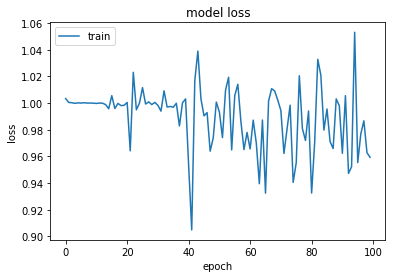

In [132]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
%%time
baseline.display_embed_space(similarity_model, 128)

In [ ]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.save_model('', similarity_model, name)
Baseline.save_result('', h, name)

In [ ]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.load_model('', name)